In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal as signal
import imageio as io
from tqdm import tqdm
import pickle, re
import cv2
import math
import sys
sys.path.insert(1, '../numphly')
import numphly as nly

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
exp_target = 'R72'
gtype_name = ['R72A10xTRPA1','R72A10xW1118','W1118xTRPA1']
sex_name = ['female','male']
h5_dir = '../../FlyBehaviorSet/DLC_tracking/'+exp_target
output_fileloc = '../../FlyBehaviorSet/'
OG_recording_folder      = 'original_recording_for_tracking/'+exp_target
converted_folder         = 'Converted/'+exp_target
cropped_recording_folder = 'cropped_recording_for_tracking'  
dir_MCAM = '../DatastreamLine_MCAM_Tracking/'
shared_data_folder = '../Shared_data/'

scorer_floor  = 'DLC_resnet152_floor_topview_12label_1uniqueJan4shuffle1_100000'
scorer_wall   = 'DLC_resnet152_wall_sideview_7labelsJan1shuffle1_90000'
scorer_cross  = 'DLC_resnet152_wall_cross_section_view_8labelFeb19shuffle1_30000'

pcutoff = 0
frame_n = 126000
frame_rate = 60
frame_n_e = frame_rate*60*30

color_BP = [(0,0,255),(0,255,0),(255,0,0)]
arena_parameters = {
    'well_radius': 8.4,  # mm
    'food_cup_radius': 3.5,  # mm
}

experiments_index  = np.load('experiments_index.npy')
fileloc_set        = np.load('experiments_directory.npy')
num_file = len(fileloc_set)
videofile_set      = np.load('experiments_well_setup.npy')
num_well = len(videofile_set)
experiments_mscore = np.load('experiments_mscore.npy',allow_pickle='TRUE').item()
crop_h = np.load('crop_h.npy')
print(len(fileloc_set))

15


In [4]:
fileloc = fileloc_set[0]
experiment_index = experiments_index[0]
well = 'v_'+experiment_index+'_'+videofile_set[0]
numBP_floor = 12
numBP_wall  = 7
numBP_cross = 8
numUniq = 1

hfile_floor = h5_dir+'/'+well+scorer_floor+'_el_filtered.h5'
Dataframe = pd.read_hdf(os.path.join(hfile_floor))
bodyparts = Dataframe.columns.get_level_values(2)[0:3*numBP_floor];
bodyparts_floor = (bodyparts[0::3])

uniqueID = Dataframe.columns.get_level_values(1)[0:3*numBP_floor*3];
uniqueID = (uniqueID[0::3*numBP_floor])[2]
paint = Dataframe.columns.get_level_values(2)[0:3*numBP_floor*3];
paint = paint[3*numBP_floor*2]





hfile_wall = h5_dir+'/'+well+scorer_wall+'_el_filtered.h5'
Dataframe = pd.read_hdf(os.path.join(hfile_wall))
bodyparts = Dataframe.columns.get_level_values(2)[0:3*numBP_wall];
bodyparts_wall = (bodyparts[0::3])

hfile_cross = h5_dir+'/'+well+scorer_cross+'_el_filtered.h5'
Dataframe = pd.read_hdf(os.path.join(hfile_cross))
bodyparts = Dataframe.columns.get_level_values(2)[0:3*numBP_cross];
bodyparts_cross = (bodyparts[0::3])


animalID = Dataframe.columns.get_level_values(1)[0:3*numBP_cross*3];
animalID = (animalID[0::3*numBP_cross])#[0:2]
n_ID = len(animalID)

numBP_floor = 6
bodyparts_floor = bodyparts_floor[[0,1,2,3,4,5]]
numBP_wall  = 5
bodyparts_wall  = bodyparts_wall[[0,1,2,3,4]]
# numBP_cross = 4
# bodyparts_cross = bodyparts_cross[[0,3,4,7]]

# print(bodyparts_floor1)
print(uniqueID,paint)
print(bodyparts_floor, len(bodyparts_floor))
print(bodyparts_wall, len(bodyparts_wall))
print(bodyparts_cross, len(bodyparts_cross))
# print(animalID)

num_exp = 0
for i in range(num_file):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    for j in range(num_well):
        sex = sexes[j]

        if sex != -1:
            num_exp = num_exp+1

single paint
Index(['head', 'eyel', 'eyer', 'center', 'tail', 'wc'], dtype='object', name='bodyparts') 6
Index(['mouth', 'head', 'center', 'tail', 'wc'], dtype='object', name='bodyparts') 5
Index(['top', 'top_l', 'top_r', 'left', 'right', 'down_l', 'down_r', 'down'], dtype='object', name='bodyparts') 8


# floor and wall
## head to center, center to tail, head to tail length standard deviation
# cross
## top to left, top to right, left to right
# floor vs paint
## head to paint, center to paint, head to paint

In [5]:
r_f_bp   = np.zeros((numBP_floor,num_exp))



numBP_floor_p = math.comb(numBP_floor, 2)
r_f_bp_x = np.empty((numBP_floor_p,num_exp))
r_w_bp = np.zeros((numBP_wall,num_exp))
r_w_bp_m   = np.zeros((numBP_wall,num_exp))
r_c_bp = np.zeros((numBP_cross,num_exp))
r_c_bp_m   = np.zeros((numBP_cross,num_exp))

r_c = np.zeros(num_exp)
# d_f_p_m    = np.zeros((2,3,num_exp))
# d_f_p_std  = np.zeros((2,3,num_exp))

frame_n_e = frame_rate*60*30
ii = 0
for i in range(num_file):
# for i in range(5):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    arena_circle = experiment['arena circle']
    experiment_index = experiments_index[i]
    start_t = np.max(experiment['starting_time'])
    well_tracker_select = np.logical_and(np.arange(frame_n)>=start_t,np.arange(frame_n)<start_t+frame_n_e)
    well_tracker_select_NaN = ~well_tracker_select
    well_coordinate = {}
    for j in range(num_well):
#     for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]
        
        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            well_arena = arena_circle[j]
            circle = np.mean(well_arena, axis = 0)
            parameter_mm2p = (arena_parameters['well_radius']/circle[2])
            radius = circle[2]
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            
            el_h5 = '_el_filtered.h5'
#             el_h5 = '_el.h5'
            hfile_wall  = h5_dir+'/'+well+scorer_wall+el_h5
            hfile_floor = h5_dir+'/'+well+scorer_floor+el_h5
            hfile_cross = h5_dir+'/'+well+scorer_cross+el_h5

            my_file_wall = Path(hfile_wall)
            my_file_floor = Path(hfile_floor)
            my_file_cross = Path(hfile_cross)
            
            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))

                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall, conf_wall   = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                loc_paint, conf_paint = nly.read_loc_paint(Dataframe_floor,scorer_floor,uniqueID, paint)
                paint_tracker = np.logical_and(loc_paint[0,:] >= 0, loc_paint[0,:] >= 0)
                paint_tracker = np.logical_and(paint_tracker, conf_paint >= 0.5)
                
                thr_cf = 0.95
                
                
                fly_tracker_f = nly.tracking_analysis_or_cf(loc_floor,conf_floor,thr_cf)
                fly_tracker_f[:,:,well_tracker_select_NaN] =  False
                fly_tracker_f_n = np.zeros((2,numBP_floor,2,frame_n))==1
                fly_tracker_f_n[:,:,0,:] = ~fly_tracker_f
                fly_tracker_f_n[:,:,1,:] = ~fly_tracker_f
                loc_floor[fly_tracker_f_n] = np.NaN
                well_tracker_f = np.logical_and(fly_tracker_f[0,:,:],fly_tracker_f[1,:,:])
                
                fly_tracker_w = nly.tracking_analysis_or_cf(loc_wall, conf_wall,thr_cf)
                fly_tracker_w[:,:,well_tracker_select_NaN] =  False
                fly_tracker_w_n = np.zeros((2,numBP_wall,2,frame_n))==1
                fly_tracker_w_n[:,:,0,:] = ~fly_tracker_w
                fly_tracker_w_n[:,:,1,:] = ~fly_tracker_w
                loc_wall[fly_tracker_w_n]  = np.NaN
                well_tracker_w = np.logical_and(fly_tracker_w[0,:,:],fly_tracker_w[1,:,:])
                
                fly_tracker_c = nly.tracking_analysis_or_cf(loc_cross,conf_cross,thr_cf)
                fly_tracker_c[:,:,well_tracker_select_NaN] =  False
                fly_tracker_c_n = np.zeros((2,numBP_cross,2,frame_n))==1
                fly_tracker_c_n[:,:,0,:] = ~fly_tracker_c
                fly_tracker_c_n[:,:,1,:] = ~fly_tracker_c
                loc_cross[fly_tracker_c_n]  = np.NaN
                well_tracker_c = np.logical_and(fly_tracker_c[0,:,:],fly_tracker_c[1,:,:])
                
                well_tracker_c_8 = np.sum(well_tracker_c,axis=0)==numBP_cross
                r_c[ii] = np.sum(well_tracker_c_8)/frame_n_e
                n_bp_f = np.sum(well_tracker_f,axis=1)
                n_bp_w = np.sum(well_tracker_w,axis=1)
                n_bp_c = np.sum(well_tracker_c,axis=1)

                r_f_bp[:,ii] = n_bp_f/frame_n_e
                r_w_bp[:,ii] = n_bp_w/frame_n_e
                r_c_bp[:,ii] = n_bp_c/frame_n_e

                
#                 well_tracker_2eyes = np.logical_and(well_tracker_f[1,:],well_tracker_f[2,:])
#                 well_tracker_head = np.logical_or(well_tracker_2eyes, well_tracker_f[0,:])
                
#                 well_tracker_2tails = np.logical_and(well_tracker_f[4,:],well_tracker_f[5,:])
#                 well_tracker_tail = np.logical_or(well_tracker_2tails, well_tracker_f[4,:])


                # Compute pairwise AND using broadcasting (shape becomes n x n x T)
                pairwise_and = well_tracker_f[:, None, :] & well_tracker_f[None, :, :]

                # Get indices for upper triangle (excluding diagonal)
                rows, cols = np.triu_indices(numBP_floor, k=1)
                n_bp_f_x   = np.sum(pairwise_and, axis=2)
                # Extract results for unique row pairs

                r_f_bp_x[:,ii] = n_bp_f_x[rows, cols]/frame_n_e
                
                print(well, r_f_bp_x.shape,
                      "%.3f"%(np.sum(well_tracker_c_8)/frame_n_e),
#                       "%.3f"%(np.sum(well_tracker_f[0,:])/frame_n_e),'     ',
#                       "%.3f"%(np.sum(well_tracker_tail)/frame_n_e),
#                       "%.3f"%(np.sum(well_tracker_f[4,:])/frame_n_e),'     ',
                     )
            else:
                print('no h files')
            ii = ii+1

v_05_08_24_exp1_A1 (15, 86) 0.218
v_05_08_24_exp1_B1 (15, 86) 0.050
v_05_08_24_exp1_D1 (15, 86) 0.026
v_05_08_24_exp1_A2 (15, 86) 0.035
v_05_08_24_exp1_B2 (15, 86) 0.288
v_05_08_24_exp2_C1 (15, 86) 0.004
v_05_08_24_exp2_D1 (15, 86) 0.009
v_05_08_24_exp2_A2 (15, 86) 0.006
v_05_08_24_exp2_B2 (15, 86) 0.038
v_05_08_24_exp2_D2 (15, 86) 0.048
v_05_09_24_exp1_A1 (15, 86) 0.016
v_05_09_24_exp1_C1 (15, 86) 0.083
v_05_09_24_exp1_D1 (15, 86) 0.039
v_05_09_24_exp1_A2 (15, 86) 0.009
v_05_09_24_exp1_B2 (15, 86) 0.068
v_05_09_24_exp1_C2 (15, 86) 0.011
v_05_09_24_exp1_D2 (15, 86) 0.001
v_05_09_24_exp2_B1 (15, 86) 0.176
v_05_09_24_exp2_C1 (15, 86) 0.010
v_05_09_24_exp2_D1 (15, 86) 0.031
v_05_09_24_exp2_A2 (15, 86) 0.009
v_05_13_24_exp1_A1 (15, 86) 0.015
v_05_13_24_exp1_D1 (15, 86) 0.005
v_05_13_24_exp1_A2 (15, 86) 0.010
v_05_13_24_exp1_B2 (15, 86) 0.106
v_05_13_24_exp1_D2 (15, 86) 0.044
v_05_13_24_exp2_B1 (15, 86) 0.027
v_05_13_24_exp2_C1 (15, 86) 0.026
v_05_13_24_exp2_D1 (15, 86) 0.040
v_05_13_24_exp

In [6]:
print(np.mean(r_c))

0.044763350559862185


In [19]:
print(np.mean(r_c))

0.04706492248062015


In [25]:
print(np.mean(r_c))

0.04519713608957794


In [17]:
print(np.mean(r_c))

0.044763350559862185


Index(['head', 'eyel', 'eyer', 'center', 'tail', 'wc'], dtype='object', name='bodyparts') 6
Index(['mouth', 'head', 'center', 'tail', 'wc'], dtype='object', name='bodyparts') 5
Index(['top', 'top_l', 'top_r', 'left', 'right', 'down_l', 'down_r', 'down'], dtype='object', name='bodyparts') 8
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] ['head', 'eyel', 'eyer', 'center', 'tail', 'wc', 'mouth', 'head', 'center', 'tail', 'wc', 'top', 'top_l', 'top_r', 'left', 'right', 'down_l', 'down_r', 'down']
['head', 'eyel', 'eyer', 'center', 'tail', 'wc', 'mouth', 'head', 'center', 'tail', 'wc', 'top', 'top_l', 'top_r', 'left', 'right', 'down_l', 'down_r', 'down']


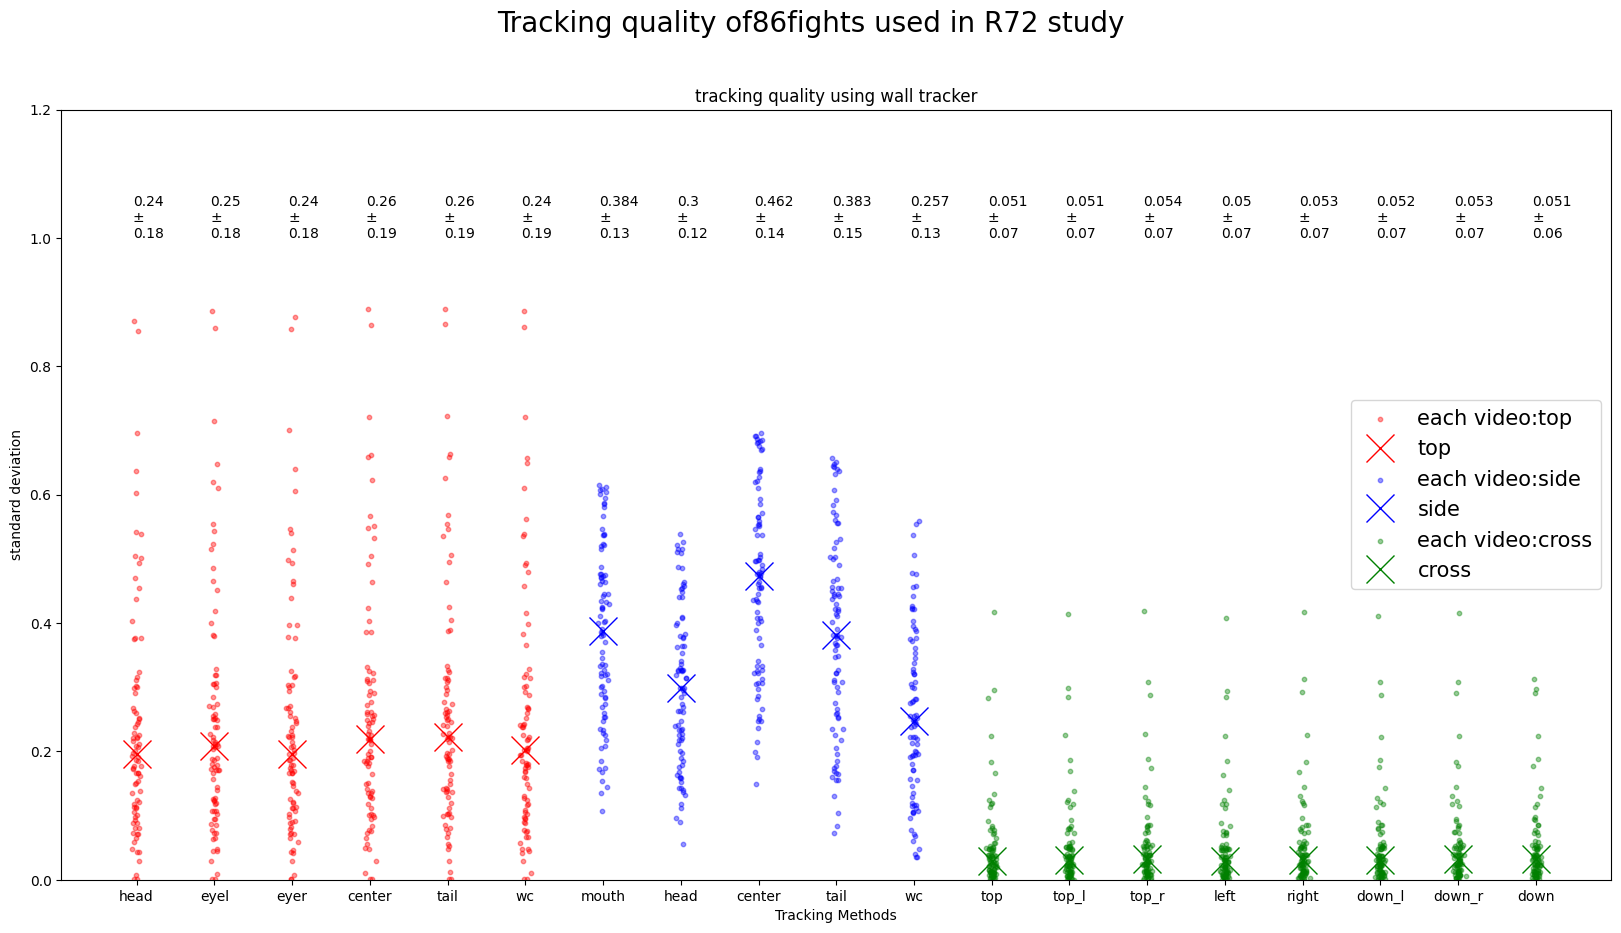

In [7]:
figure, axs = plt.subplots(1,1, figsize=(20,10))
figure.suptitle('Tracking quality of'+str(num_exp)+'fights used in '+exp_target+' study', fontsize=20)
fontsize = 10
ms = 10
alpha = 0.4
y_text = 1
# Generate sample data

x_shift = -0.2
bodyparts = []
x_positions_all = np.arange(numBP_floor+numBP_wall+numBP_cross)
print(bodyparts_floor, len(bodyparts_floor))
print(bodyparts_wall, len(bodyparts_wall))
print(bodyparts_cross, len(bodyparts_cross))
for bp in bodyparts_floor: bodyparts.append(bp)
for bp in bodyparts_wall: bodyparts.append(bp)
for bp in bodyparts_cross: bodyparts.append(bp)
# bodyparts.append(bodyparts_floor)
# bodyparts.append(bodyparts_wall)
# bodyparts.append(bodyparts_cross)


print(x_positions_all, bodyparts)
x_positions = np.arange(len(bodyparts_floor))




# # Calculate means for each category
means = np.mean(r_f_bp, axis=1)
stds = np.std(r_f_bp, axis=1)
medians = np.median(r_f_bp, axis=1)
# axs.bar(x_positions, means, alpha=0.7, label='floor tracker', width = 0.2)


 
for i_bp in range(numBP_floor):
# Jitter x-coordinates around category position
    x = np.random.normal(x_positions[i_bp], 0.03, size=num_exp)
    axs.scatter(x, r_f_bp[i_bp,:], color='red', alpha=alpha, s=ms,
                label='each video:top' if i_bp == 0 else "")
    axs.plot(x_positions[i_bp], medians[i_bp], 'xr', ms = ms*2, label='top' if i_bp == 0 else "")
    m = means[i_bp]
    d = stds[i_bp]
    axs.text(x_positions[i_bp]-0.05,y_text,str(np.round(m, decimals=2))+'\n\xB1\n'+str(np.round(d, decimals=2)),
             fontsize = fontsize)
    

x_positions = np.arange(len(bodyparts_wall))+numBP_floor

# # Calculate means for each category
means = np.mean(r_w_bp, axis=1)
stds = np.std(r_w_bp, axis=1)
medians = np.median(r_w_bp, axis=1)
# axs.bar(x_positions, means, alpha=0.7, label='floor tracker', width = 0.2)


 
for i_bp in range(numBP_wall):
# Jitter x-coordinates around category position
    x = np.random.normal(x_positions[i_bp], 0.03, size=num_exp)
    axs.scatter(x, r_w_bp[i_bp,:], color='blue', alpha=alpha, s=ms,
                label='each video:side' if i_bp == 0 else "")
    axs.plot(x_positions[i_bp], medians[i_bp], 'xb', ms = ms*2, label='side' if i_bp == 0 else "")
    m = means[i_bp]
    d = stds[i_bp]
    axs.text(x_positions[i_bp]-0.05,y_text,str(np.round(m, decimals=3))+'\n\xB1\n'+str(np.round(d, decimals=2)),
             fontsize = fontsize)

    
x_positions = np.arange(len(bodyparts_cross))+numBP_wall+numBP_floor

# # Calculate means for each category
means = np.mean(r_c_bp, axis=1)
stds = np.std(r_c_bp, axis=1)
medians = np.median(r_c_bp, axis=1)
# axs.bar(x_positions, means, alpha=0.7, label='floor tracker', width = 0.2)


 
for i_bp in range(numBP_cross):
# Jitter x-coordinates around category position
    x = np.random.normal(x_positions[i_bp], 0.03, size=num_exp)
    axs.scatter(x, r_c_bp[i_bp,:], color='green', alpha=alpha, s=ms,
                label='each video:cross' if i_bp == 0 else "")
    axs.plot(x_positions[i_bp], medians[i_bp], 'xg', ms = ms*2, label='cross' if i_bp == 0 else "")
    m = means[i_bp]
    d = stds[i_bp]
    axs.text(x_positions[i_bp]-0.05,y_text,str(np.round(m, decimals=3))+'\n\xB1\n'+str(np.round(d, decimals=2)),
             fontsize = fontsize)    
    
    
    

axs.legend(fontsize=15, loc='center right')
axs.set_title('tracking quality using wall tracker')
axs.set_xlabel('Tracking Methods')
axs.set_ylabel('standard deviation')
axs.set_ylim([0,1.2])
# axs.set_xlim([-0.5,6.7])
# axs.set_yticks([0,20,40,60,80,100], labels=[0,20,40,60,80,100])
# categories = ['PTQ', 'FTQ 1', 'FTQ 2', 'PMTQ', 'FMTQ 1', 'FMTQ 2']
axs.set_xticks(x_positions_all, labels=bodyparts)
print(bodyparts)

['head', 'eyel', 'eyer', 'center', 'tail', 'wc', 'mouth', 'head', 'center', 'tail', 'wc', 'wo1', 'wo2', 'top', 'top_l', 'top_r', 'left', 'right', 'down_l', 'down_r', 'down'] [0.20875    0.20627778 0.20875    0.20846296 0.20713889 0.21411111
 0.21725926 0.21697222 0.21562037 0.21410185 0.21385185 0.2125
 0.21783333 0.21643519 0.21683333] [0.19701852 0.19346296 0.19707407 0.19694444 0.184      0.19643519
 0.20356481 0.20344444 0.18998148 0.19660185 0.19644444 0.18325926
 0.21152778 0.19774074 0.20010185]


(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4]),
 array([1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]))

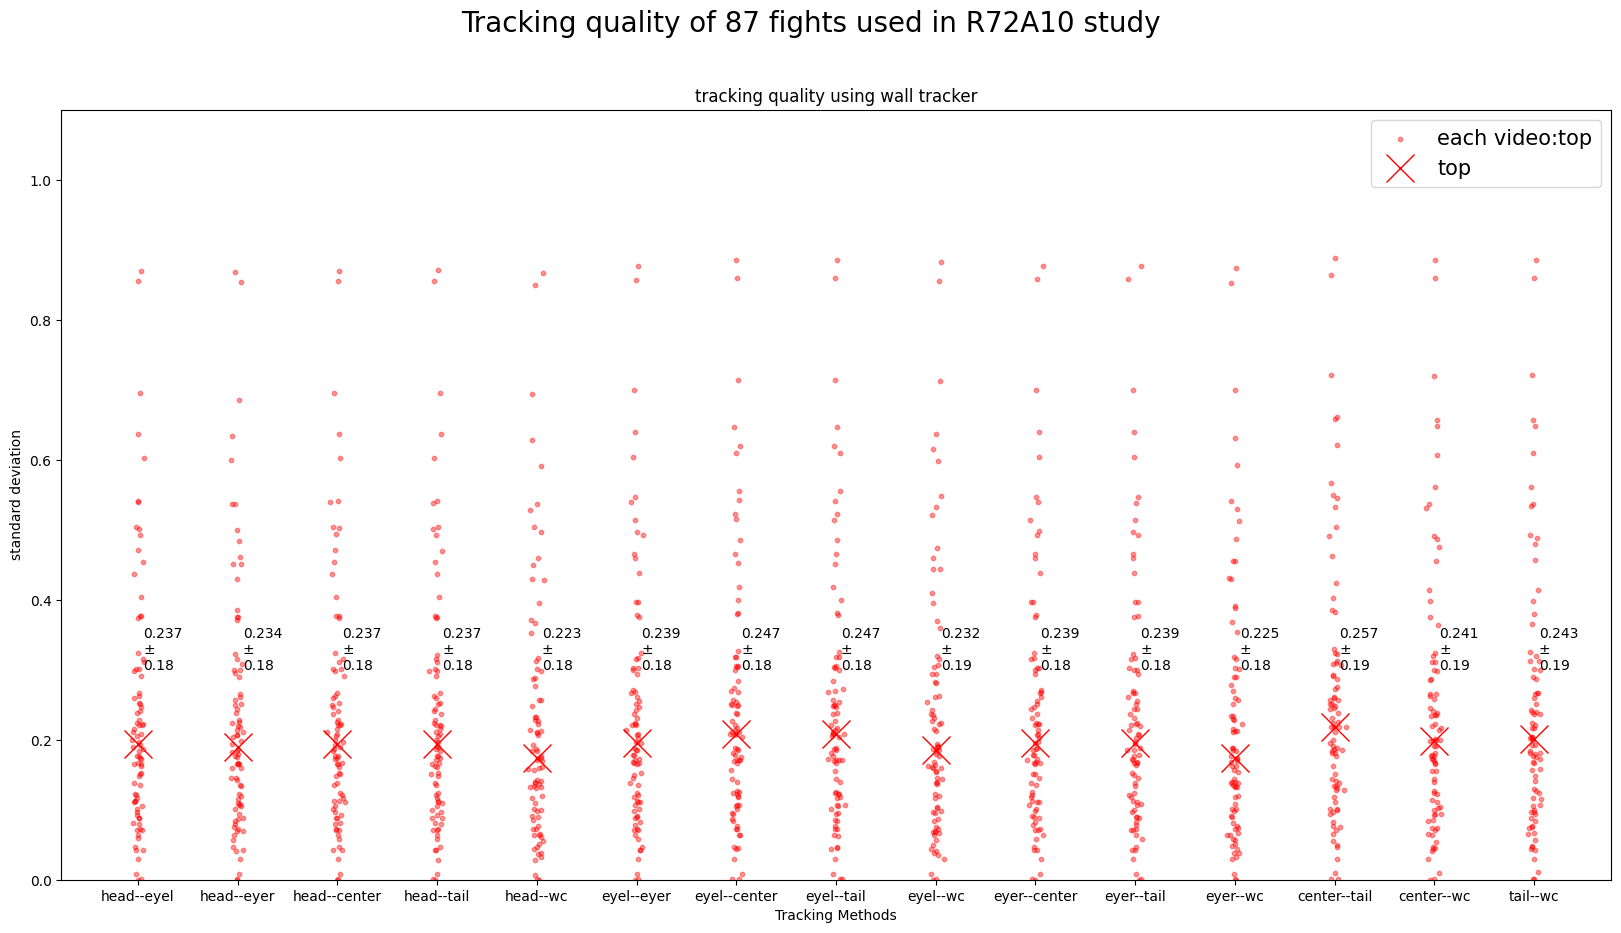

In [9]:
figure, axs = plt.subplots(1,1, figsize=(20,10))
figure.suptitle('Tracking quality of 87 fights used in R72A10 study', fontsize=20)
fontsize = 10
ms = 10
alpha = 0.4
y_text = 0.3
# Generate sample data

x_shift = -0.2
bodyparts_p = []
x_positions_all = np.arange(numBP_floor_p)
# print(bodyparts_floor, len(bodyparts_floor))
# print(bodyparts_wall, len(bodyparts_wall))
# print(bodyparts_cross, len(bodyparts_cross))
for i_bp_x in range(numBP_floor_p):
    i_bp_1 = rows[i_bp_x]
    i_bp_2 = cols[i_bp_x]
    bodyparts_p.append(bodyparts_floor[i_bp_1]+'--'+bodyparts_floor[i_bp_2])
# for bp in bodyparts_wall: bodyparts.append(bp)
# for bp in bodyparts_cross: bodyparts.append(bp)
# bodyparts.append(bodyparts_floor)
# bodyparts.append(bodyparts_wall)
# bodyparts.append(bodyparts_cross)
# print(x_positions_all, bodyparts)



x_positions = np.arange(numBP_floor_p)

# # Calculate means for each category
means = np.mean(r_f_bp_x, axis=1)
stds = np.std(r_f_bp_x, axis=1)
medians = np.median(r_f_bp_x, axis=1)
# axs.bar(x_positions, means, alpha=0.7, label='floor tracker', width = 0.2)


 
for i_bp in range(numBP_floor_p):
# Jitter x-coordinates around category position
    x = np.random.normal(x_positions[i_bp], 0.03, size=num_exp)
    axs.scatter(x, r_f_bp_x[i_bp,:], color='red', alpha=alpha, s=ms,
                label='each video:top' if i_bp == 0 else "")
    axs.plot(x_positions[i_bp], medians[i_bp], 'xr', ms = ms*2, label='top' if i_bp == 0 else "")
    m = means[i_bp]
    d = stds[i_bp]
    axs.text(x_positions[i_bp]+0.05,y_text,str(np.round(m, decimals=3))+'\n\xB1\n'+str(np.round(d, decimals=2)),
             fontsize = fontsize)
    

# x_positions = np.arange(len(bodyparts_wall))+numBP_floor

# # # Calculate means for each category
# means = np.mean(r_w_bp, axis=1)
# stds = np.std(r_w_bp, axis=1)
# medians = np.median(r_w_bp, axis=1)
# # axs.bar(x_positions, means, alpha=0.7, label='floor tracker', width = 0.2)


 
# for i_bp in range(numBP_wall):
# # Jitter x-coordinates around category position
#     x = np.random.normal(x_positions[i_bp], 0.03, size=num_exp)
#     axs.scatter(x, r_w_bp[i_bp,:], color='blue', alpha=alpha, s=ms,
#                 label='each video:side' if i_bp == 0 else "")
#     axs.plot(x_positions[i_bp], medians[i_bp], 'xb', ms = ms*2, label='side' if i_bp == 0 else "")
#     m = means[i_bp]
#     d = stds[i_bp]
#     axs.text(x_positions[i_bp]-0.05,y_text,str(np.round(m, decimals=3))+'\n\xB1\n'+str(np.round(d, decimals=2)),
#              fontsize = fontsize)

    
# x_positions = np.arange(len(bodyparts_cross))+numBP_wall+numBP_floor

# # # Calculate means for each category
# means = np.mean(r_c_bp, axis=1)
# stds = np.std(r_c_bp, axis=1)
# medians = np.median(r_c_bp, axis=1)
# # axs.bar(x_positions, means, alpha=0.7, label='floor tracker', width = 0.2)


 
# for i_bp in range(numBP_cross):
# # Jitter x-coordinates around category position
#     x = np.random.normal(x_positions[i_bp], 0.03, size=num_exp)
#     axs.scatter(x, r_c_bp[i_bp,:], color='green', alpha=alpha, s=ms,
#                 label='each video:cross' if i_bp == 0 else "")
#     axs.plot(x_positions[i_bp], medians[i_bp], 'xg', ms = ms*2, label='cross' if i_bp == 0 else "")
#     m = means[i_bp]
#     d = stds[i_bp]
#     axs.text(x_positions[i_bp]-0.05,y_text,str(np.round(m, decimals=3))+'\n\xB1\n'+str(np.round(d, decimals=2)),
#              fontsize = fontsize)    
    
    
    

axs.legend(fontsize=15)
axs.set_title('tracking quality using wall tracker')
axs.set_xlabel('Tracking Methods')
axs.set_ylabel('standard deviation')
axs.set_ylim([0,1.1])
# axs.set_xlim([-0.5,6.7])
# axs.set_yticks([0,20,40,60,80,100], labels=[0,20,40,60,80,100])
# categories = ['PTQ', 'FTQ 1', 'FTQ 2', 'PMTQ', 'FMTQ 1', 'FMTQ 2']
axs.set_xticks(x_positions_all, labels=bodyparts_p)
print(bodyparts, r_f_bp_x[:,0],r_f_bp_x[:,1])

rows, cols

# floor and wall
## speed

# floor and wall
## head to head, center to center, tail to tail length standard deviation

# floor and wall and cross
## average distance between flies in different trackers

TypeError: tracking_analysis_eql() missing 2 required positional arguments: 'thr' and 'thr_bp'

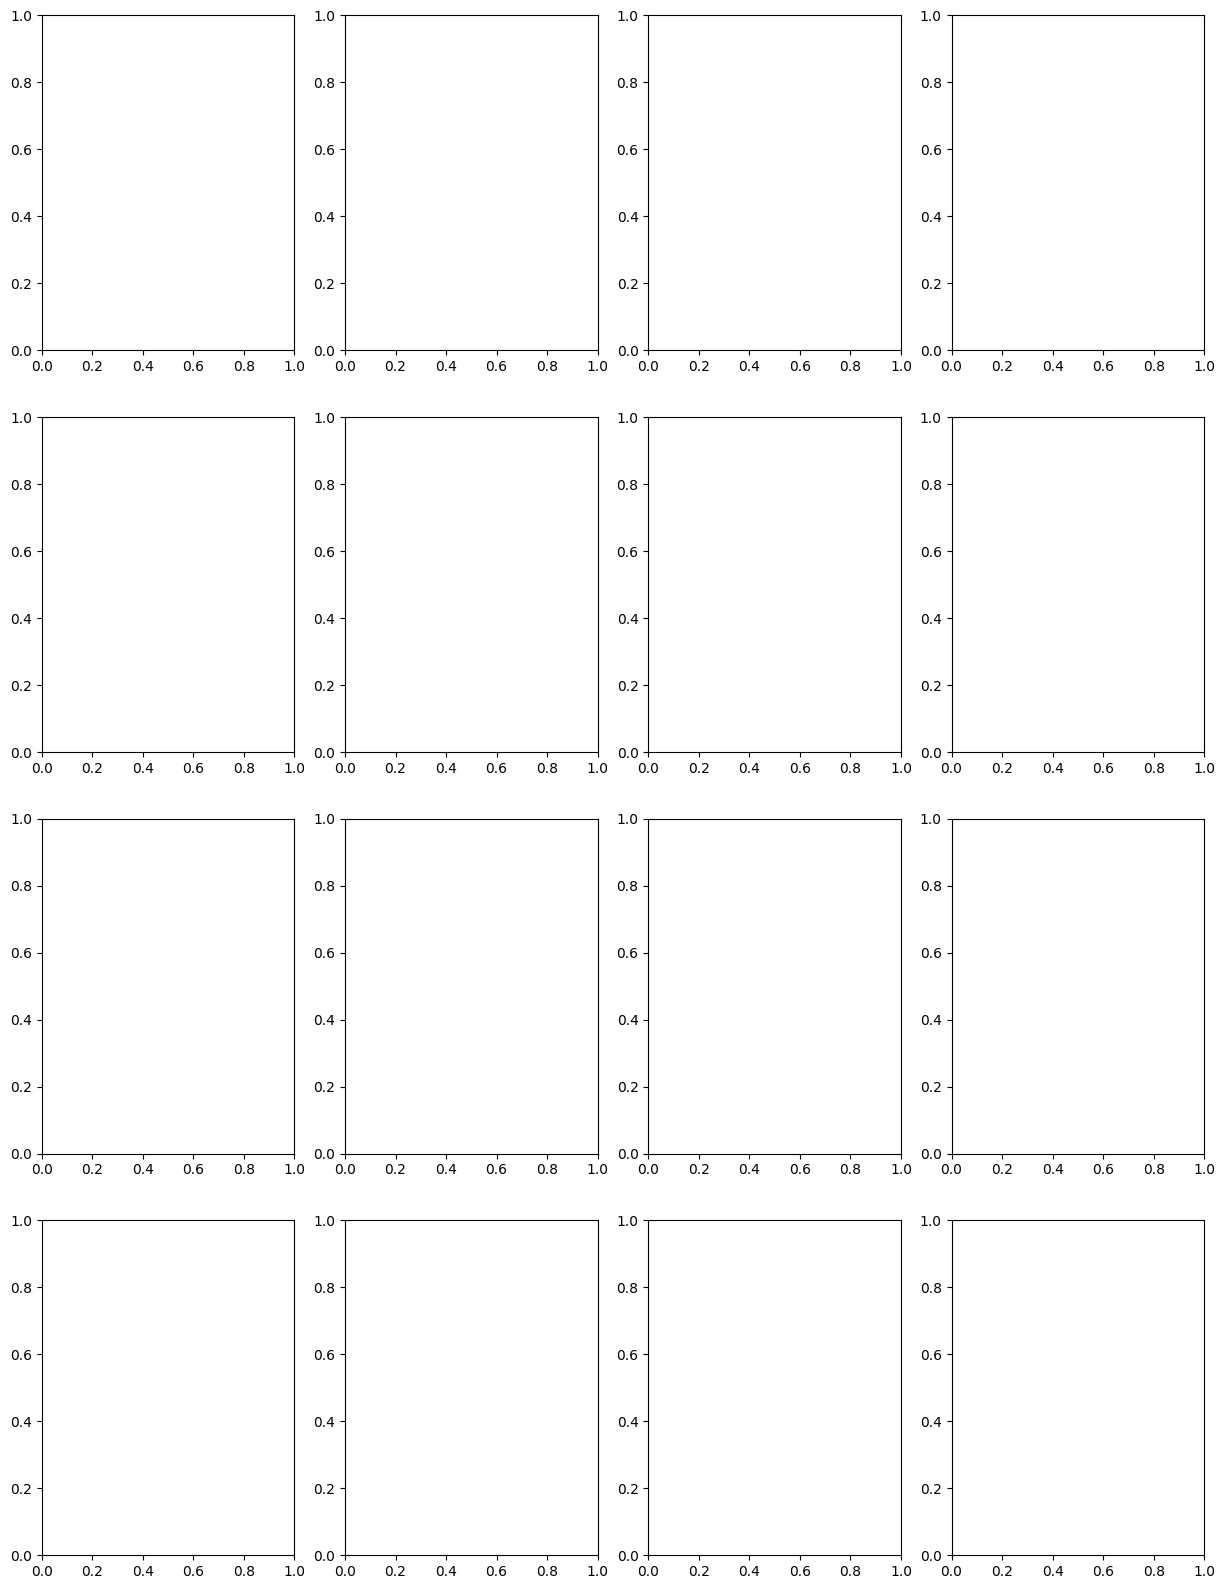

In [10]:
figure, axs = plt.subplots(4,4, figsize=(15,20))
np.set_printoptions(precision=2)
bins_dff = np.linspace(0, 399, num=400)



thr_h = 5
# thr = 3
ii = 0
# for i in range(num_file):
for i in range(7):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    arena_circle = experiment['arena circle']
    experiment_index = experiments_index[i]
    well_coordinate = {}
#     for j in range(num_well):
    for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]
        
        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            well_arena = arena_circle[j]
            circle = np.mean(well_arena, axis = 0)
            radius = circle[2]
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            
#             el_h5 = '_el_filtered.h5'
            el_h5 = '_el.h5'
            hfile_wall = h5_dir+'/'+well+scorer_wall+el_h5
            
            hfile_floor = h5_dir+'/'+well+scorer_floor+el_h5
            
            hfile_cross = h5_dir+'/'+well+scorer_cross+el_h5
            
            
            my_file_wall = Path(hfile_wall)
            my_file_floor = Path(hfile_floor)
            my_file_cross = Path(hfile_cross)
            
            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall, conf_wall   = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                
                conf_f_bp = np.sum(conf_floor, axis = 1)
                conf_w_bp = np.sum(conf_wall, axis = 1)
                conf_c_bp = np.sum(conf_cross, axis = 1)
                
                loc_f_m = np.mean(loc_floor, axis = 1)
                loc_w_m = np.mean(loc_wall, axis = 1)
                loc_c_m = np.mean(loc_cross, axis = 1)
                
                fly_tracker_floor_e = nly.tracking_analysis_eql(loc_floor)
                fly_tracker_wall_e  = nly.tracking_analysis_eql(loc_wall)
                fly_tracker_cross_e = nly.tracking_analysis_eql(loc_cross)
                
                
                f_tkr_fandc_e = np.logical_and(fly_tracker_floor_e, fly_tracker_cross_e)
                f_tkr_wandc_e = np.logical_and(fly_tracker_wall_e, fly_tracker_cross_e)
                
                # distance fly 1 in f_track
                d_ff = np.zeros((4,frame_n))
                d_ff[0,:] = np.sqrt(np.sum(np.square(loc_f_m[0,:,:]-loc_w_m[0,:,:]),axis=0))
                d_ff[1,:] = np.sqrt(np.sum(np.square(loc_f_m[0,:,:]-loc_w_m[1,:,:]),axis=0))
                d_ff[2,:] = np.sqrt(np.sum(np.square(loc_f_m[1,:,:]-loc_w_m[0,:,:]),axis=0))
                d_ff[3,:] = np.sqrt(np.sum(np.square(loc_f_m[1,:,:]-loc_w_m[1,:,:]),axis=0))
                f_tkr_e = np.logical_and(fly_tracker_floor_e, fly_tracker_wall_e)
                labels = ['f1_w1','f1_w2','f2_w1','f2_w2']
                
#                 d_ff[0,:] = np.sqrt(np.sum(np.square(loc_f_m[0,:,:]-loc_c_m[0,:,:]),axis=0))
#                 d_ff[1,:] = np.sqrt(np.sum(np.square(loc_f_m[0,:,:]-loc_c_m[1,:,:]),axis=0))
#                 d_ff[2,:] = np.sqrt(np.sum(np.square(loc_f_m[1,:,:]-loc_c_m[0,:,:]),axis=0))
#                 d_ff[3,:] = np.sqrt(np.sum(np.square(loc_f_m[1,:,:]-loc_c_m[1,:,:]),axis=0))
#                 labels = ['f1_c1','f1_c2','f2_c1','f2_c2']
                
#                 d_ff[0,:] = np.sqrt(np.sum(np.square(loc_c_m[0,:,:]-loc_w_m[0,:,:]),axis=0))
#                 d_ff[1,:] = np.sqrt(np.sum(np.square(loc_c_m[0,:,:]-loc_w_m[1,:,:]),axis=0))
#                 d_ff[2,:] = np.sqrt(np.sum(np.square(loc_c_m[1,:,:]-loc_w_m[0,:,:]),axis=0))
#                 d_ff[3,:] = np.sqrt(np.sum(np.square(loc_c_m[1,:,:]-loc_w_m[1,:,:]),axis=0))
#                 labels = ['c1_w1','c1_w2','c2_w1','c2_w2']
                
                for i_bp in range(4):

                    axs[ii,i_bp].hist(d_ff[i_bp,f_tkr_e],       bins_dff, edgecolor='black',
                                      label = labels[i_bp])
                    axs[ii,i_bp].legend();axs[ii,i_bp].set_ylim([0,750])
                    
            else:
                print('no h files')
            ii = ii+1



# floor and wall and cross
## exclusive tracking

v_05_08_24_exp1_A1 [1440 2054  848 3001]
v_05_09_24_exp1_A1 [3460 3579 3081 3769]
v_05_13_24_exp1_A1 [3037 2848 2504 3264]
v_05_13_24_exp3_A1 [4359 4004 4247 3615]
v_05_15_24_exp1_A1 [5709 3563 9398 9728]


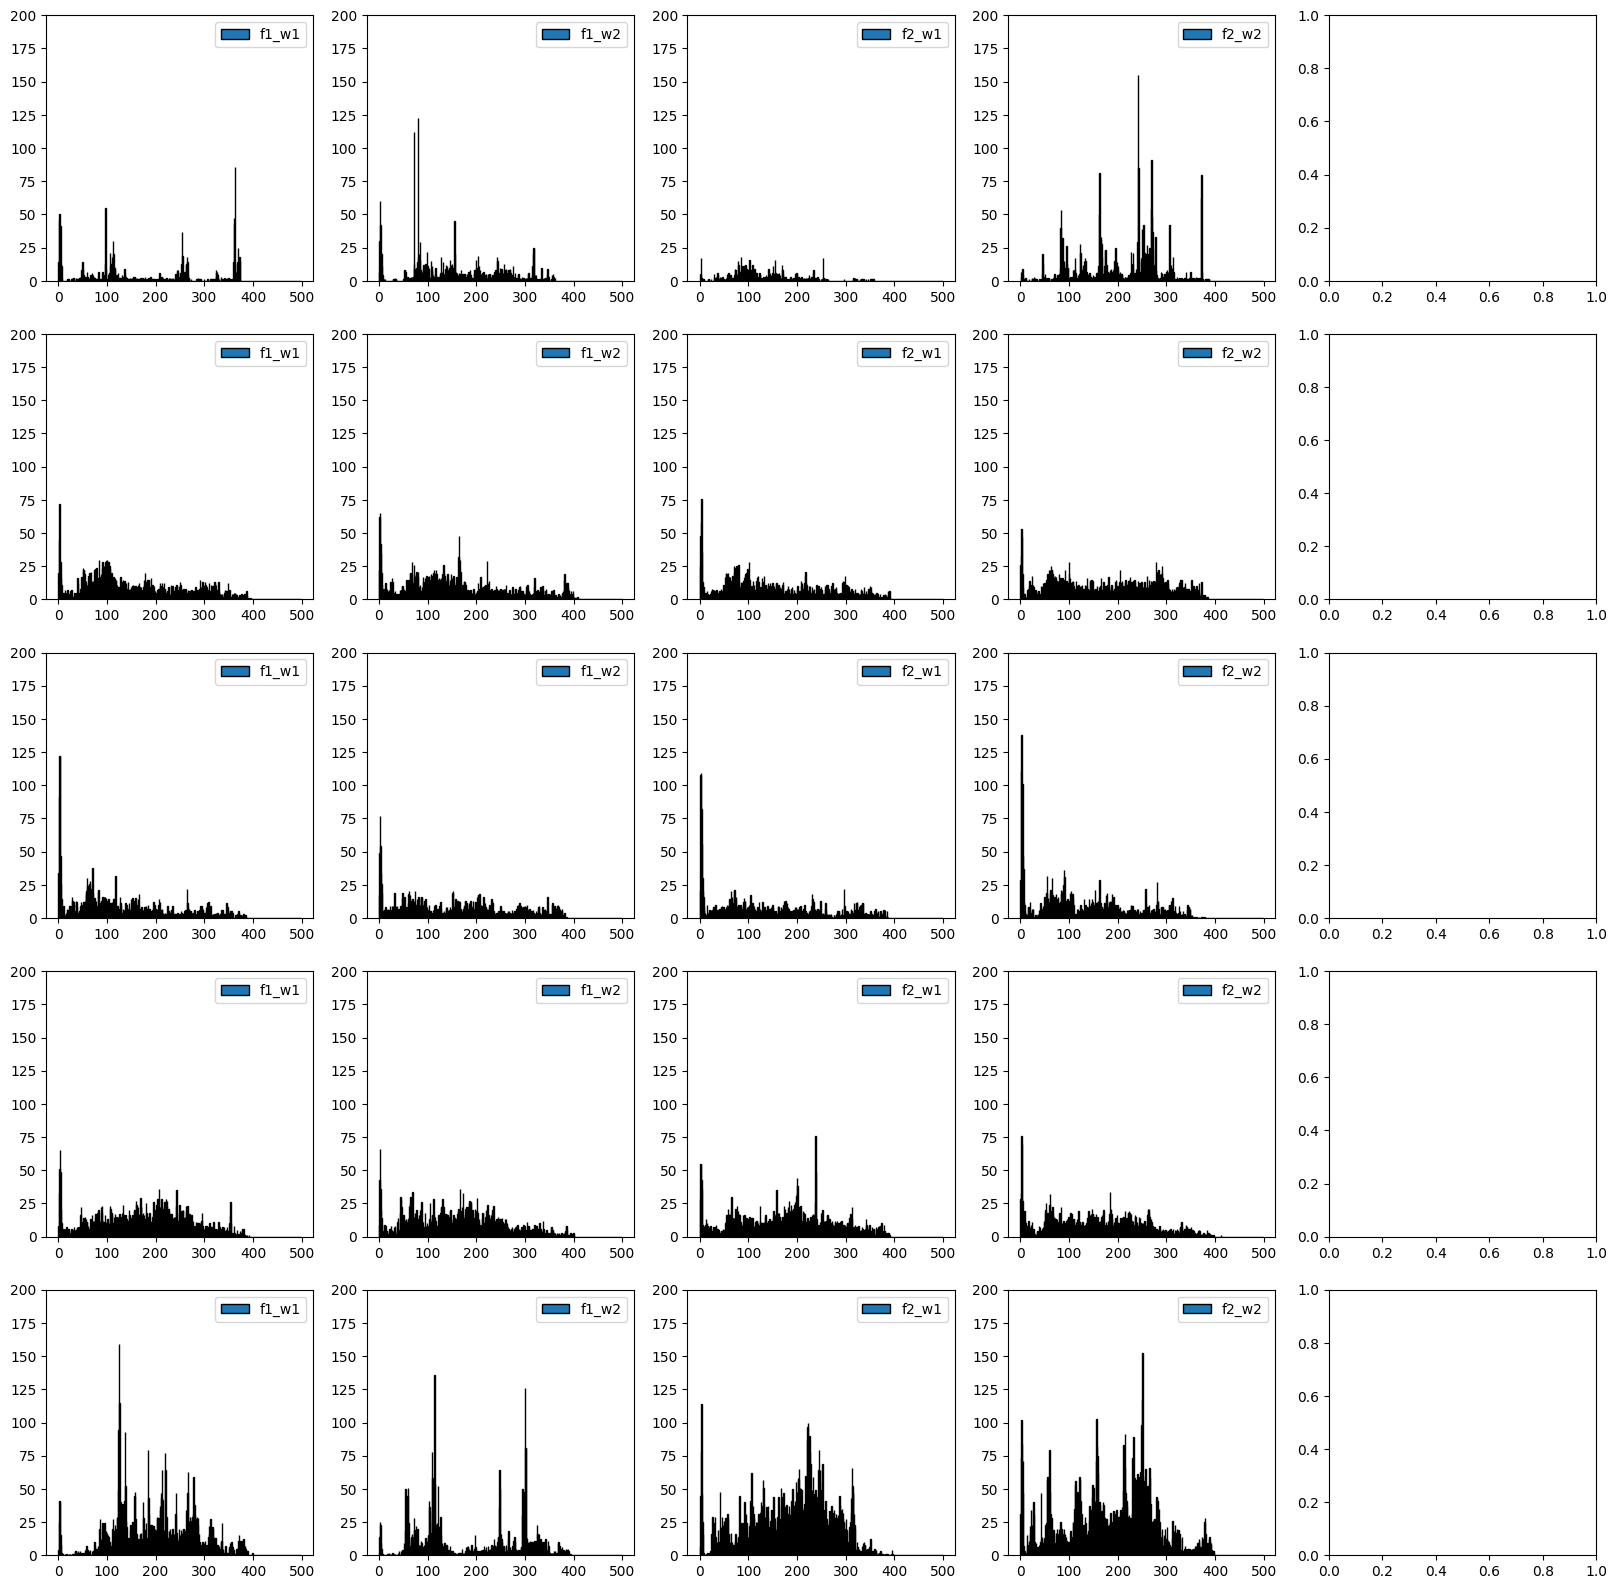

In [57]:
figure, axs = plt.subplots(5,4, figsize=(20,20))
np.set_printoptions(precision=2)




thr_h = 5
# thr = 3
ii = 0
# for i in range(num_file):
for i in range(8):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    arena_circle = experiment['arena circle']
    experiment_index = experiments_index[i]
    well_coordinate = {}
#     for j in range(num_well):
    for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]
        
        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            well_arena = arena_circle[j]
            circle = np.mean(well_arena, axis = 0)
            radius = circle[2]
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            
            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el_filtered.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el_filtered.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el_filtered.h5'
            my_file_cross = Path(hfile_cross)
            
            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall, conf_wall   = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                
                conf_f_bp = np.sum(conf_floor, axis = 1)
                conf_w_bp = np.sum(conf_wall, axis = 1)
                conf_c_bp = np.sum(conf_cross, axis = 1)
                
                loc_f_m = np.mean(loc_floor, axis = 1)
                loc_w_m = np.mean(loc_wall, axis = 1)
                loc_c_m = np.mean(loc_cross, axis = 1)
                
                fly_tracker_floor_e = nly.tracking_analysis_eql(loc_floor)
                fly_tracker_wall_e  = nly.tracking_analysis_eql(loc_wall)
                fly_tracker_cross_e = nly.tracking_analysis_eql(loc_cross)
                
                f1_tkr_f = np.logical_and(conf_f_bp[0,:] == numBP_floor, np.isnan(conf_f_bp[1,:]))
                f2_tkr_f = np.logical_and(conf_f_bp[1,:] == numBP_floor, np.isnan(conf_f_bp[0,:]))
                f1_tkr_w = np.logical_and(conf_w_bp[0,:] == numBP_wall,  np.isnan(conf_w_bp[1,:]))
                f2_tkr_w = np.logical_and(conf_w_bp[1,:] == numBP_wall,  np.isnan(conf_w_bp[0,:]))
                
                f_tkr_e = np.logical_and(fly_tracker_floor_e, fly_tracker_wall_e)
                tkr_ff = np.zeros((4,frame_n)) == 0
                tkr_ff[0,:] = np.logical_and(np.logical_and(f1_tkr_f,f1_tkr_w), f_tkr_e)
                tkr_ff[1,:] = np.logical_and(np.logical_and(f1_tkr_f,f2_tkr_w), f_tkr_e)
                tkr_ff[2,:] = np.logical_and(np.logical_and(f2_tkr_f,f1_tkr_w), f_tkr_e)
                tkr_ff[3,:] = np.logical_and(np.logical_and(f2_tkr_f,f2_tkr_w), f_tkr_e)
                
                print(well, np.sum(tkr_ff,axis=1))
                
                d_ff = np.zeros((4,frame_n))
                d_ff[0,:] = np.sqrt(np.sum(np.square(loc_f_m[0,:,:]-loc_w_m[0,:,:]),axis=0))
                d_ff[1,:] = np.sqrt(np.sum(np.square(loc_f_m[0,:,:]-loc_w_m[1,:,:]),axis=0))
                d_ff[2,:] = np.sqrt(np.sum(np.square(loc_f_m[1,:,:]-loc_w_m[0,:,:]),axis=0))
                d_ff[3,:] = np.sqrt(np.sum(np.square(loc_f_m[1,:,:]-loc_w_m[1,:,:]),axis=0))
                
                labels = ['f1_w1','f1_w2','f2_w1','f2_w2']
                bins_dff = np.linspace(0, 499, num=500)
                for i_bp in range(4):

                    axs[ii,i_bp].hist(d_ff[i_bp, tkr_ff[i_bp,:]], 
                                      bins_dff, edgecolor='black', label = labels[i_bp])
                    axs[ii,i_bp].legend();axs[ii,i_bp].set_ylim([0,200])
                    
            else:
                print('no h files')
            ii = ii+1



In [34]:
np.set_printoptions(precision=2)

ii = 0
# for i in range(num_file):
for i in range(5):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    arena_circle = experiment['arena circle']
    experiment_index = experiments_index[i]
    well_coordinate = {}
#     for j in range(num_well):
    for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]
        
        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            well_arena = arena_circle[j]
            circle = np.mean(well_arena, axis = 0)
            radius = circle[2]
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            
            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el_filtered.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el_filtered.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el_filtered.h5'
            my_file_cross = Path(hfile_cross)
            
            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall, conf_wall   = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                
                conf_f_bp = np.sum(conf_floor, axis = 1)
                conf_w_bp = np.sum( conf_wall, axis = 1)
                
                loc_f_m = np.mean(loc_floor, axis = 1)
                loc_w_m = np.mean(loc_wall, axis = 1)
                
                fly_tracker_floor   = nly.tracking_analysis_and(loc_floor,conf_floor)
                fly_tracker_wall    = nly.tracking_analysis_and(loc_wall, conf_wall)
                fly_tracker_cross   = nly.tracking_analysis_and(loc_cross, conf_cross)
                
#                 fly_tracker_floor = np.logical_and(fly_tracker_floor, conf_f_bp == numBP_floor)
#                 fly_tracker_wall  = np.logical_and(fly_tracker_wall,  conf_w_bp == numBP_wall)
#                 loc_f_m = np.nanmean(loc_floor, axis = 1)
#                 loc_w_m = np.nanmean(loc_wall, axis = 1)
#                 fly_tracker_floor   = nly.tracking_analysis_or(loc_floor,conf_floor)
#                 fly_tracker_wall    = nly.tracking_analysis_or(loc_wall, conf_wall)
#                 fly_tracker_cross   = nly.tracking_analysis_or(loc_cross, conf_cross)
                
                fly_tracker_floor_e = nly.tracking_analysis_eql(loc_floor)
                fly_tracker_wall_e  = nly.tracking_analysis_eql(loc_wall)
                fly_tracker_cross_e = nly.tracking_analysis_eql(loc_cross)
                
                fly_tracker_floor_wall_e = np.logical_and(~fly_tracker_floor_e, ~fly_tracker_wall_e)
                fly_tracker_e            = np.logical_and(fly_tracker_floor_wall_e, ~fly_tracker_cross_e)

                fly_tracker_floor[0,:] = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor_e)
                fly_tracker_floor[1,:] = np.logical_and(fly_tracker_floor[1,:], fly_tracker_floor_e)
                
                fly_tracker_wall[0,:]  = np.logical_and(fly_tracker_wall[0,:], fly_tracker_wall_e)
                fly_tracker_wall[1,:]  = np.logical_and(fly_tracker_wall[1,:], fly_tracker_wall_e)
                
                fly_tracker_cross[0,:] = np.logical_and(fly_tracker_cross[0,:], fly_tracker_cross_e)
                fly_tracker_cross[1,:] = np.logical_and(fly_tracker_cross[1,:], fly_tracker_cross_e)
                
                well_tracker_floor = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor[1,:])
                well_tracker_wall  = np.logical_and(fly_tracker_wall[0,:],  fly_tracker_wall[1,:])
                well_tracker_cross = np.logical_and(fly_tracker_cross[0,:], fly_tracker_cross[1,:])
                well_tracker_floor_wall = np.logical_or(well_tracker_floor,      well_tracker_wall)
                well_tracker            = np.logical_or(well_tracker_floor_wall, well_tracker_cross)
                
                well_tracker_fandw = np.logical_and(well_tracker_floor,      well_tracker_wall)
                
                # distance fly 1 in f_track
                d_f1f1 = np.sqrt(np.sum(np.square(loc_f_m[0,:,:]-loc_w_m[0,:,:]),axis=0))
                d_f1f2 = np.sqrt(np.sum(np.square(loc_f_m[0,:,:]-loc_w_m[1,:,:]),axis=0))
                d_f2f1 = np.sqrt(np.sum(np.square(loc_f_m[1,:,:]-loc_w_m[0,:,:]),axis=0))
                d_f2f2 = np.sqrt(np.sum(np.square(loc_f_m[1,:,:]-loc_w_m[1,:,:]),axis=0))
                
                f1f1_tracker = np.logical_and(fly_tracker_floor[0,:], fly_tracker_wall[0,:])
                f1f2_tracker = np.logical_and(fly_tracker_floor[0,:], fly_tracker_wall[1,:])
                f2f1_tracker = np.logical_and(fly_tracker_floor[1,:], fly_tracker_wall[0,:])
                f2f2_tracker = np.logical_and(fly_tracker_floor[1,:], fly_tracker_wall[1,:])
                
                d_f1f1_m = np.mean(d_f1f1[f1f1_tracker])
                d_f1f2_m = np.mean(d_f1f2[f1f2_tracker])
                d_f2f1_m = np.mean(d_f2f1[f2f1_tracker])
                d_f2f2_m = np.mean(d_f2f2[f2f2_tracker])
#                 
                fw_11_22 = d_f1f1_m <= d_f1f2_m and d_f2f2_m <= d_f2f1_m
                fw_12_21 = d_f1f1_m >= d_f1f2_m and d_f2f2_m >= d_f2f1_m
        
                T_wall_f1  = sum(fly_tracker_wall[0,:])
                T_wall_f2  = sum(fly_tracker_wall[1,:]) 
                T_floor_f1 = sum(fly_tracker_floor[0,:])
                T_floor_f2 = sum(fly_tracker_floor[1,:])
        
                if d_f1f1_m <= d_f1f2_m:
                    if d_f2f2_m <= d_f2f1_m:
                        print(well, "1 is 1, 2 is 2")
                    
                    else:
                        print("f1f1:","%.2f"%d_f1f1_m, "f1f2:","%.2f"%d_f1f2_m, )
                        print("f2f1:","%.2f"%d_f2f1_m, "f2f2:","%.2f"%d_f2f2_m, )
                elif d_f1f1_m > d_f1f2_m:
                    if d_f2f2_m >= d_f2f1_m:
                        print(well, "1 is 2, 2 is 1")
                    else:
                        print("f1f1:","%.2f"%d_f1f1_m, "f1f2:","%.2f"%d_f1f2_m, )
                        print("f2f1:","%.2f"%d_f2f1_m, "f2f2:","%.2f"%d_f2f2_m, )
                else:
                    print(well, "%.2f"% (d_f1f1_m/d_f1f2_m), "%.2f"% (d_f2f1_m/d_f2f2_m))

            else:
                print('no h files')
            ii = ii+1



v_05_08_24_exp1_A1 1 is 2, 2 is 1
v_05_09_24_exp1_A1 1 is 2, 2 is 1
f1f1: 81.37 f1f2: 111.57
f2f1: 87.78 f2f2: 96.03


In [77]:
np.set_printoptions(precision=2)

ii = 0
for i in range(num_file):
# for i in range(5):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    arena_circle = experiment['arena circle']
    experiment_index = experiments_index[i]
    well_coordinate = {}
    for j in range(num_well):
#     for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]
        
        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            well_arena = arena_circle[j]
            circle = np.mean(well_arena, axis = 0)
            radius = circle[2]
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            
            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el_filtered.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el_filtered.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el_filtered.h5'
            my_file_cross = Path(hfile_cross)
            
            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall, conf_wall   = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                
                

                
                
                
                conf_f_bp = np.sum(conf_floor, axis = 1)
                conf_w_bp = np.sum( conf_wall, axis = 1)
                loc_f_m = np.mean(loc_floor, axis = 1)
                loc_w_m = np.mean(loc_wall, axis = 1)
                
                fly_tracker_floor   = nly.tracking_analysis_and(loc_floor,conf_floor)
                fly_tracker_wall    = nly.tracking_analysis_and(loc_wall, conf_wall)
                fly_tracker_cross   = nly.tracking_analysis_and(loc_cross, conf_cross)
                
#                 fly_tracker_floor   = nly.tracking_analysis_or(loc_floor,conf_floor)
#                 fly_tracker_wall    = nly.tracking_analysis_or(loc_wall, conf_wall)
#                 fly_tracker_cross   = nly.tracking_analysis_or(loc_cross, conf_cross)
                
                fly_tracker_floor_e = nly.tracking_analysis_eql(loc_floor)
                fly_tracker_wall_e  = nly.tracking_analysis_eql(loc_wall)
                fly_tracker_cross_e = nly.tracking_analysis_eql(loc_cross)
                
                fly_tracker_floor_wall_e = np.logical_and(~fly_tracker_floor_e, ~fly_tracker_wall_e)
                fly_tracker_e = np.logical_and(fly_tracker_floor_wall_e, ~fly_tracker_cross_e)
                
#                 print(well, sum(fly_tracker_floor_wall_e), sum(fly_tracker_e))
#                 print(sum(~fly_tracker_floor_e), sum(~fly_tracker_wall_e), sum(~fly_tracker_cross_e))
                
                fly_tracker_floor[0,:] = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor_e)
                fly_tracker_floor[1,:] = np.logical_and(fly_tracker_floor[1,:], fly_tracker_floor_e)
                
                fly_tracker_wall[0,:]  = np.logical_and(fly_tracker_wall[0,:], fly_tracker_wall_e)
                fly_tracker_wall[1,:]  = np.logical_and(fly_tracker_wall[1,:], fly_tracker_wall_e)
                
                fly_tracker_cross[0,:] = np.logical_and(fly_tracker_cross[0,:], fly_tracker_cross_e)
                fly_tracker_cross[1,:] = np.logical_and(fly_tracker_cross[1,:], fly_tracker_cross_e)
                
                
                f_f_p1p2_tkr, f_f_p2p3_tkr, f_f_p1p3_tkr = (
                    nly.tracking_analysis_bp_outliers(loc_floor,5))
                f_w_p1p2_tkr, f_w_p2p3_tkr, f_w_p1p3_tkr = (
                    nly.tracking_analysis_bp_outliers(loc_wall,5))
                f_f_pp_tkr = np.logical_and(np.logical_and(f_f_p1p2_tkr,f_f_p1p2_tkr),f_f_p1p3_tkr)
                f_w_pp_tkr = np.logical_and(np.logical_and(f_w_p1p2_tkr,f_w_p1p2_tkr),f_w_p1p3_tkr)
                
#                 f_c_p1p2_tkr, f_c_p2p3_tkr, f_c_p1p3_tkr = (
#                     nly.tracking_analysis_bp_outliers(loc_cross,5))
                
                fly_tracker_floor = np.logical_and(fly_tracker_floor, f_f_pp_tkr)
                fly_tracker_wall  = np.logical_and(fly_tracker_wall,  f_w_pp_tkr)
            
                well_tracker_floor = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor[1,:])
                well_tracker_wall  = np.logical_and(fly_tracker_wall[0,:],  fly_tracker_wall[1,:])
                well_tracker_cross = np.logical_and(fly_tracker_cross[0,:], fly_tracker_cross[1,:])
                well_tracker_floor_wall = np.logical_or(well_tracker_floor,      well_tracker_wall)
                well_tracker            = np.logical_or(well_tracker_floor_wall, well_tracker_cross)
                

                #identify frames when floor tracker and wall tracker both see 2 flies
                
                idx_frames = np.arange(frame_n)
                well_tracker_fandw = np.logical_and(well_tracker_floor, well_tracker_wall)
                idx_frames_fandw   = idx_frames[well_tracker_fandw]
                
                
                well_tracker_forw = np.logical_or(well_tracker_floor, well_tracker_wall)
                idx_frames_forw   = idx_frames[well_tracker_forw]
                
                fwc_tracker = np.zeros(frame_n)
                # 2D array , 4 by frame_n, to code fly id, 0 or 1
                # view 0: nothing, 1:f, w:2, 3:c
                
                loc_code = np.zeros((2,2,frame_n))
                n_mismatch = np.zeros(19).astype('int')
                for idx_i_fw in idx_frames_forw:
                    conf_f_i = conf_f_bp[:,idx_i_fw]
                    conf_w_i = conf_w_bp[:,idx_i_fw]
                    
                    loc_f_m_i = loc_f_m[:,:,idx_i_fw]
                    loc_w_m_i = loc_w_m[:,:,idx_i_fw]
                    loc_code_i, n_mismatch = nly.tracker_ID_View_classifer(
                        conf_f_i, conf_w_i, loc_f_m_i, loc_w_m_i, n_mismatch)
                    loc_code[:,:,idx_i_fw] = loc_code_i
                
                
                
#                 fly_tracker_floor_xor = np.logical_xor(fly_tracker_floor[0,:], fly_tracker_floor[1,:])
#                 fly_tracker_floor_xor = np.logical_or(fly_tracker_floor_xor, ~fly_tracker_floor_e)
                
#                 fly_tracker_wall_xor  = np.logical_xor(fly_tracker_wall[0,:],  fly_tracker_wall[1,:])
#                 fly_tracker_wall_xor  = np.logical_or(fly_tracker_wall_xor, ~fly_tracker_wall_e)
                
#                 fly_tracker_cross_xor = np.logical_xor(fly_tracker_cross[0,:], fly_tracker_cross[1,:])
#                 fly_tracker_cross_xor = np.logical_or(fly_tracker_cross_xor, ~fly_tracker_cross_e)
                
#                 fly_tracker_fw = np.logical_and(fly_tracker_floor_xor, fly_tracker_wall_xor)
#                 fly_tracker_fc = np.logical_and(fly_tracker_floor_xor, fly_tracker_cross_xor)
#                 fly_tracker_wc = np.logical_and(fly_tracker_wall_xor,  fly_tracker_cross_xor)
                
                
#                 print(well,n_mismatch[0:8], len(idx_frames_forw)-np.sum(n_mismatch))
                print(well, n_mismatch[2], n_mismatch[6])
#                 print(well,n_mismatch[0:8])
#                 print(well,n_mismatch[8:16])
        

       

            else:
                print('no h files')
            ii = ii+1



v_05_08_24_exp1_A1 0 1
v_05_08_24_exp1_B1 1 0
v_05_08_24_exp1_D1 3 2
v_05_08_24_exp1_A2 1 0
v_05_08_24_exp1_B2 0 0
v_05_08_24_exp2_C1 2 2
v_05_08_24_exp2_D1 0 0
v_05_08_24_exp2_A2 2 2
v_05_08_24_exp2_B2 1 4
v_05_08_24_exp2_D2 0 0
v_05_09_24_exp1_A1 1 4
v_05_09_24_exp1_C1 2 3
v_05_09_24_exp1_D1 0 0
v_05_09_24_exp1_A2 2 1
v_05_09_24_exp1_B2 2 2
v_05_09_24_exp1_C2 1 3
v_05_09_24_exp1_D2 1 2
v_05_09_24_exp2_B1 0 0
v_05_09_24_exp2_C1 2 4
v_05_09_24_exp2_D1 1 1
v_05_09_24_exp2_A2 0 1
v_05_13_24_exp1_A1 1 3
v_05_13_24_exp1_D1 4 0
v_05_13_24_exp1_A2 4 1
v_05_13_24_exp1_B2 1 1
v_05_13_24_exp1_D2 0 2
v_05_13_24_exp2_B1 0 0
v_05_13_24_exp2_C1 4 1
v_05_13_24_exp2_D1 0 0
v_05_13_24_exp2_C2 1 0
v_05_13_24_exp3_A1 1 2
v_05_13_24_exp3_B1 0 2
v_05_13_24_exp3_C1 1 2
v_05_13_24_exp3_D1 1 2
v_05_15_24_exp1_A1 3 2
v_05_15_24_exp1_B1 0 0
v_05_15_24_exp1_C1 0 1
v_05_15_24_exp1_D1 0 0
v_05_15_24_exp1_A2 3 0
v_05_15_24_exp1_B2 0 1
v_05_15_24_exp1_C2 0 0
v_05_15_24_exp1_D2 0 1
v_05_17_24_exp1_A1 1 2
v_05_17_24_

In [4]:
np.set_printoptions(precision=2)

ii = 0
for i in range(num_file):
# for i in range(5):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    arena_circle = experiment['arena circle']
    experiment_index = experiments_index[i]
    well_coordinate = {}
    for j in range(num_well):
#     for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]
        
        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            well_arena = arena_circle[j]
            circle = np.mean(well_arena, axis = 0)
            radius = circle[2]
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            
            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el_filtered.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el_filtered.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el_filtered.h5'
            my_file_cross = Path(hfile_cross)
            
            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall, conf_wall   = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                
                conf_f_bp = np.sum(conf_floor, axis = 1)
                conf_w_bp = np.sum( conf_wall, axis = 1)
#                 loc_f_m = np.mean(loc_floor, axis = 1)
#                 loc_w_m = np.mean(loc_wall, axis = 1)
                
                fly_tracker_floor   = nly.tracking_analysis_and(loc_floor,conf_floor)
                fly_tracker_wall    = nly.tracking_analysis_and(loc_wall, conf_wall)
                fly_tracker_cross   = nly.tracking_analysis_and(loc_cross, conf_cross)
                
#                 fly_tracker_floor   = nly.tracking_analysis_or(loc_floor,conf_floor)
#                 fly_tracker_wall    = nly.tracking_analysis_or(loc_wall, conf_wall)
#                 fly_tracker_cross   = nly.tracking_analysis_or(loc_cross, conf_cross)
                
                fly_tracker_floor_e = nly.tracking_analysis_eql(loc_floor)
                fly_tracker_wall_e  = nly.tracking_analysis_eql(loc_wall)
                fly_tracker_cross_e = nly.tracking_analysis_eql(loc_cross)
                
                fly_tracker_floor_wall_e = np.logical_and(~fly_tracker_floor_e, ~fly_tracker_wall_e)
                fly_tracker_e = np.logical_and(fly_tracker_floor_wall_e, ~fly_tracker_cross_e)
                
#                 print(well, sum(fly_tracker_floor_wall_e), sum(fly_tracker_e))
#                 print(sum(~fly_tracker_floor_e), sum(~fly_tracker_wall_e), sum(~fly_tracker_cross_e))
                
                fly_tracker_floor[0,:] = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor_e)
                fly_tracker_floor[1,:] = np.logical_and(fly_tracker_floor[1,:], fly_tracker_floor_e)
                
                fly_tracker_wall[0,:]  = np.logical_and(fly_tracker_wall[0,:], fly_tracker_wall_e)
                fly_tracker_wall[1,:]  = np.logical_and(fly_tracker_wall[1,:], fly_tracker_wall_e)
                
                fly_tracker_cross[0,:] = np.logical_and(fly_tracker_cross[0,:], fly_tracker_cross_e)
                fly_tracker_cross[1,:] = np.logical_and(fly_tracker_cross[1,:], fly_tracker_cross_e)
                
                well_tracker_floor = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor[1,:])
                well_tracker_wall  = np.logical_and(fly_tracker_wall[0,:],  fly_tracker_wall[1,:])
                well_tracker_cross = np.logical_and(fly_tracker_cross[0,:], fly_tracker_cross[1,:])
                well_tracker_floor_wall = np.logical_or(well_tracker_floor,      well_tracker_wall)
                well_tracker            = np.logical_or(well_tracker_floor_wall, well_tracker_cross)
                
#                 print(well, "intersect", 
#                       "f&w", sum(np.logical_and(well_tracker_floor, well_tracker_wall)),
#                       "w&c", sum(np.logical_and(well_tracker_wall,  well_tracker_cross)),
#                       "f&c", sum(np.logical_and(well_tracker_floor, well_tracker_cross)),
#                       'c',   sum(well_tracker_cross),
#                      )
                #identify frames when floor tracker and wall tracker both see 2 flies
                idx_frames = np.arange(frame_n)
                well_tracker_fandw = np.logical_and(well_tracker_floor, well_tracker_wall)
                idx_frames_fandw   = idx_frames[well_tracker_fandw]
                
                fwc_tracker = np.zeros(frame_n)
                # 2D array , 4 by frame_n, to code fly id, 0 or 1
                # view 0: nothing, 1:f, w:2, 3:c
                
                loc_code = np.zeros((2,2,frame_n))
                for idx_i_fw in idx_frames_fandw:
                    conf_f_i = conf_f_bp[:,idx_i_fw]
                    conf_w_i = conf_w_bp[:,idx_i_fw]
                    
                    loc_f_m = np.mean(loc_floor[:,:,:,idx_i_fw], axis = 1)
                    loc_w_m = np.mean(loc_wall [:,:,:,idx_i_fw], axis = 1)
                    
#                     if sum(conf_f_i) == 6 and sum(conf_w_i) == 6:
#                     if sum(conf_f_i) == numBP_floor*n_ID:
                    if min(conf_f_i) >= max(conf_w_i)
                        loc_code[0,0,idx_i_fw] = 0
                        loc_code[1,0,idx_i_fw] = 1
                    elif :
                        loc_code[0,0,idx_i_fw] = 0
                        loc_code[1,0,idx_i_fw] = 1
                    else:
                        dfw_11 = np.sqrt(np.sum(np.square(loc_f_m[0,:]-loc_w_m[0,:])))
                        dfw_12 = np.sqrt(np.sum(np.square(loc_f_m[0,:]-loc_w_m[1,:])))
                        dfw_21 = np.sqrt(np.sum(np.square(loc_f_m[1,:]-loc_w_m[0,:])))
                        dfw_22 = np.sqrt(np.sum(np.square(loc_f_m[1,:]-loc_w_m[1,:])))
                        
                        dff_12 = np.sqrt(np.sum(np.square(loc_f_m[0,:]-loc_f_m[1,:])))
                        dww_12 = np.sqrt(np.sum(np.square(loc_w_m[0,:]-loc_w_m[1,:])))
                        # floor fly 1 is wall fly 1, floor fly 2 is wall fly 2
                        if dfw_11<dfw_12 and dfw_22<dfw_21:
                            
                            loc_code[0,0,idx_i_fw] = 0
                            loc_code[1,0,idx_i_fw] = 1
                            
#                             print("floor 0","%.5f" % conf_f_i[0], "wall 0","%.5f" % conf_w_i[0],)
                            # floor fly 1 tracking result is better than wall fly 1 tracking result
                            if conf_f_i[0] >= conf_w_i[0]:
                                loc_code[0,1,idx_i_fw] = 0
                            # floor fly 1 tracking result is worse than wall fly 1 tracking result
                            else:
                                loc_code[0,1,idx_i_fw] = 1
                                
#                             print("floor 1","%.5f" % conf_f_i[1], "wall 1","%.5f" % conf_w_i[1],)
                            # floor fly 2 tracking result is better than wall fly 2 tracking result
                            if conf_f_i[1] >= conf_w_i[1]:
                                loc_code[1,1,idx_i_fw] = 0
                            # floor fly 2 tracking result is worse than wall fly 2 tracking result
                            else:
                                loc_code[1,1,idx_i_fw] = 1   
                            
                        # floor fly 1 is wall fly 2, floor fly 2 is wall fly 1
                        elif dfw_11 >= dfw_12 and dfw_22 >= dfw_21:
#                             loc_code[0,0,idx_i_fw] = 0
#                             loc_code[1,0,idx_i_fw] = 1
                            # floor fly 1 tracking result is better than wall fly 2 tracking result
                            if conf_f_i[0] >= conf_w_i[1]:
                                loc_code[0,0,idx_i_fw] = 0
                                loc_code[1,0,idx_i_fw] = 1
                                loc_code[0,1,idx_i_fw] = 0
                            # floor fly 1 tracking result is worse than wall fly 2 tracking result
                            else:
                                loc_code[0,0,idx_i_fw] = 1
                                loc_code[1,0,idx_i_fw] = 0
                                loc_code[0,1,idx_i_fw] = 1
                                
#                             print("floor 1","%.5f" % conf_f_i[1], "wall 1","%.5f" % conf_w_i[1],)
                            # floor fly 2 tracking result is better than wall fly 1 tracking result
                            if conf_f_i[1] >= conf_w_i[0]:
                                loc_code[0,0,idx_i_fw] = 0
                                loc_code[1,0,idx_i_fw] = 1
                                loc_code[1,1,idx_i_fw] = 0
                            # floor fly 2 tracking result is worse than wall fly 1 tracking result
                            else:
                                loc_code[0,0,idx_i_fw] = 1
                                loc_code[1,0,idx_i_fw] = 0
                                loc_code[1,1,idx_i_fw] = 1
                        else:
                            # floor tracker fly 1 and fly 2
                            if dff_12 > fww_12:
                                loc_code[0,0,idx_i_fw] = 0
                                loc_code[1,0,idx_i_fw] = 1
                                loc_code[0,1,idx_i_fw] = 0
                                loc_code[1,1,idx_i_fw] = 0
                            else:
                                loc_code[0,0,idx_i_fw] = 0
                                loc_code[1,0,idx_i_fw] = 1
                                loc_code[0,1,idx_i_fw] = 1
                                loc_code[1,1,idx_i_fw] = 1
                            print(well, idx_i_fw)
                            print('mismatch',
                                  "%.2f"%dfw_11, "%.2f"%dfw_12, 
                                  "%.2f"%dfw_21, "%.2f"%dfw_22)
                            
                            print('mismatch',
                                  "%.5f"%conf_f_i[0], "%.5f"%conf_f_i[1], "%.5f"%conf_w_i[0], "%.5f"%conf_w_i[1])
                            print(loc_f_m)
                            print(loc_w_m)
                            
                            
                            
                            video   = output_fileloc+converted_folder+fileloc_set[i]+'well_'+videofile_set[j]+'_ts.mp4'
                            PATH_FOI = output_fileloc + converted_folder
                            shutil.copyfile(video, PATH_FOI+output_file_prefix+'_ts.mp4')
                            print(video)
                            
#                     if sum(conf_f_i) < sum(conf_w_i):
#                         closest_pairs = find_closest_pairs(loc_f_m, loc_w_m)
#                         print(closest_pairs)
#                         print(idx_i_fw, conf_f_i, conf_w_i)
#                         print('floor',loc_f_m[0,:], loc_f_m[1,:])
#                         print('wall ',loc_w_m[0,:], loc_w_m[1,:])
                        
#                         dfw_11 = np.sqrt(np.sum(np.square(loc_f_m[0,:]-loc_w_m[0,:])))
#                         dfw_12 = np.sqrt(np.sum(np.square(loc_f_m[0,:]-loc_w_m[1,:])))
#                         dfw_21 = np.sqrt(np.sum(np.square(loc_f_m[1,:]-loc_w_m[0,:])))
#                         dfw_22 = np.sqrt(np.sum(np.square(loc_f_m[1,:]-loc_w_m[1,:])))
                        
#                         if dfw_11 < dfw_21:
#                             dfw_22
                            
                            
                            
#                 print(conf_floor.shape)
#                 fly_tracker_floor_xor = np.logical_xor(fly_tracker_floor[0,:], fly_tracker_floor[1,:])
#                 fly_tracker_floor_xor = np.logical_or(fly_tracker_floor_xor, ~fly_tracker_floor_e)
                
#                 fly_tracker_wall_xor  = np.logical_xor(fly_tracker_wall[0,:],  fly_tracker_wall[1,:])
#                 fly_tracker_wall_xor  = np.logical_or(fly_tracker_wall_xor, ~fly_tracker_wall_e)
                
#                 fly_tracker_cross_xor = np.logical_xor(fly_tracker_cross[0,:], fly_tracker_cross[1,:])
#                 fly_tracker_cross_xor = np.logical_or(fly_tracker_cross_xor, ~fly_tracker_cross_e)
                
#                 fly_tracker_fw = np.logical_and(fly_tracker_floor_xor, fly_tracker_wall_xor)
#                 fly_tracker_fc = np.logical_and(fly_tracker_floor_xor, fly_tracker_cross_xor)
#                 fly_tracker_wc = np.logical_and(fly_tracker_wall_xor,  fly_tracker_cross_xor)
                
                
                
#                 fly_tracker_fwc = np.logical_or(np.logical_or(fly_tracker_fw,fly_tracker_fc),fly_tracker_wc)


                

                
#                 well_tracker_all = np.logical_or(well_tracker, fly_tracker_fwc)
        

#                 print(well, ii, sex, 
#                       'floor',     "%.2f" % (sum(well_tracker_floor)/126000),
#                       'wall',      "%.2f" % (sum(well_tracker_wall)/126000),
#                       'floor&wall',"%.2f" % (sum(well_tracker_floor_wall)/126000),
#                       'fwc',"%.2f" % (sum(well_tracker_all)/126000),
#                      )
        
        
        

       

            else:
                print('no h files')
            ii = ii+1



v_05_09_24_exp1_D2 95814
mismatch 7.25 3.26 143.72 141.45
mismatch 2.99900 3.00000 3.00000 3.00000
[[211.56 430.96]
 [249.47 293.64]]
[[218.17 433.92]
 [214.81 430.78]]
v_05_13_24_exp2_D1 122290
mismatch 388.68 2.81 388.44 2.54
mismatch 2.99900 2.99900 3.00000 3.00000
[[413.09 333.74]
 [413.09 333.33]]
[[101.   102.06]
 [415.03 331.71]]
v_07_23_24_exp2_A1 25344
mismatch 8.52 92.82 8.93 92.89
mismatch 2.38600 2.38600 3.00000 3.00000
[[ 26.53 266.4 ]
 [ 26.08 266.4 ]]
[[ 34.37 269.72]
 [ 40.41 174.63]]
v_07_23_24_exp2_A1 121694
mismatch 340.14 1.96 337.77 11.49
mismatch 2.30800 2.30800 3.00000 3.00000
[[211.45 441.51]
 [206.11 433.42]]
[[437.32 187.19]
 [213.13 442.52]]
v_07_23_24_exp2_A1 125260
mismatch 0.33 132.70 1.63 133.21
mismatch 2.99600 2.99600 3.00000 3.00000
[[255.28  31.8 ]
 [255.28  29.92]]
[[255.49  31.54]
 [127.36  67.09]]


In [5]:
np.set_printoptions(precision=2)

ii = 0
for i in range(num_file):
# for i in range(5):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    arena_circle = experiment['arena circle']
    experiment_index = experiments_index[i]
    well_coordinate = {}
    for j in range(num_well):
#     for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]
        
        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            well_arena = arena_circle[j]
            circle = np.mean(well_arena, axis = 0)
            d_xy = [576/2, 576/2]-circle[0:2]-48
            
            radius = circle[2]
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            
            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el_filtered.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el_filtered.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el_filtered.h5'
            my_file_cross = Path(hfile_cross)
            
            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall, conf_wall   = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                
                conf_f_bp = np.sum(conf_floor, axis = 1)
                conf_w_bp = np.sum(conf_wall, axis = 1)
                conf_c_bp = np.sum(conf_cross, axis = 1)
                
                loc_f_m = np.mean(loc_floor, axis = 1)
                loc_w_m = np.mean(loc_wall, axis = 1)
                loc_c_m = np.mean(loc_cross, axis = 1)
                
#                 fly_tracker_floor   = nly.tracking_analysis_and(loc_floor,conf_floor)
#                 fly_tracker_wall    = nly.tracking_analysis_and(loc_wall, conf_wall)
#                 fly_tracker_cross   = nly.tracking_analysis_and(loc_cross, conf_cross)
                
#                 fly_tracker_floor   = nly.tracking_analysis_or(loc_floor,conf_floor)
#                 fly_tracker_wall    = nly.tracking_analysis_or(loc_wall, conf_wall)
#                 fly_tracker_cross   = nly.tracking_analysis_or(loc_cross, conf_cross)
                
#                 fly_tracker_floor_e = nly.tracking_analysis_eql(loc_floor)
#                 fly_tracker_wall_e  = nly.tracking_analysis_eql(loc_wall)
#                 fly_tracker_cross_e = nly.tracking_analysis_eql(loc_cross)
                
#                 fly_tracker_floor_wall_e = np.logical_and(~fly_tracker_floor_e, ~fly_tracker_wall_e)
#                 fly_tracker_e = np.logical_and(fly_tracker_floor_wall_e, ~fly_tracker_cross_e)
                
                
#                 fly_tracker_floor[0,:] = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor_e)
#                 fly_tracker_floor[1,:] = np.logical_and(fly_tracker_floor[1,:], fly_tracker_floor_e)
                
#                 fly_tracker_wall[0,:]  = np.logical_and(fly_tracker_wall[0,:], fly_tracker_wall_e)
#                 fly_tracker_wall[1,:]  = np.logical_and(fly_tracker_wall[1,:], fly_tracker_wall_e)
                
#                 fly_tracker_cross[0,:] = np.logical_and(fly_tracker_cross[0,:], fly_tracker_cross_e)
#                 fly_tracker_cross[1,:] = np.logical_and(fly_tracker_cross[1,:], fly_tracker_cross_e)
                
#                 well_tracker_floor = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor[1,:])
#                 well_tracker_wall  = np.logical_and(fly_tracker_wall[0,:],  fly_tracker_wall[1,:])
#                 well_tracker_cross = np.logical_and(fly_tracker_cross[0,:], fly_tracker_cross[1,:])
#                 well_tracker_floor_wall = np.logical_or(well_tracker_floor,      well_tracker_wall)
#                 well_tracker            = np.logical_or(well_tracker_floor_wall, well_tracker_cross)
                
#                 fly_tracker_floor_xor = np.logical_xor(fly_tracker_floor[0,:], fly_tracker_floor[1,:])
#                 fly_tracker_floor_xor = np.logical_or(fly_tracker_floor_xor, ~fly_tracker_floor_e)
                
#                 fly_tracker_wall_xor  = np.logical_xor(fly_tracker_wall[0,:],  fly_tracker_wall[1,:])
#                 fly_tracker_wall_xor  = np.logical_or(fly_tracker_wall_xor, ~fly_tracker_wall_e)
                
#                 fly_tracker_cross_xor = np.logical_xor(fly_tracker_cross[0,:], fly_tracker_cross[1,:])
#                 fly_tracker_cross_xor = np.logical_or(fly_tracker_cross_xor, ~fly_tracker_cross_e)
                
#                 fly_tracker_fw = np.logical_and(fly_tracker_floor_xor, fly_tracker_wall_xor)
#                 fly_tracker_fc = np.logical_and(fly_tracker_floor_xor, fly_tracker_cross_xor)
#                 fly_tracker_wc = np.logical_and(fly_tracker_wall_xor,  fly_tracker_cross_xor)
#                 fly_tracker_fwc = np.logical_or(np.logical_or(fly_tracker_fw,fly_tracker_fc),fly_tracker_wc)
#                 well_tracker_all = np.logical_or(well_tracker, fly_tracker_fwc)
#                 print("%.4f" % (sum(well_tracker_all)/126000))
                
    
                #identify frames well tracker
                idx_frames = np.arange(frame_n)
            
#                 well_tracker_fandw = np.logical_and(well_tracker_floor, well_tracker_wall)
#                 idx_frames_fandw   = idx_frames[well_tracker_fandw]
#                 well_tracker_forw = np.logical_or(well_tracker_floor, well_tracker_wall)
#                 idx_frames_forw   = idx_frames[well_tracker_forw]
                
#                 # 2D array , 4 by frame_n, to code fly id, 0 or 1
#                 # view 0: nothing, 1:f, w:2, 3:c
#                 fwc_tracker = np.zeros(frame_n)
#                 loc_code = np.zeros((2,2,frame_n))
#                 video   = output_fileloc+converted_folder+fileloc_set[i]+'well_'+videofile_set[j]+'_ts.mp4'
#                 cap = cv2.VideoCapture(video)

                tracking_Type = np.zeros((3,16)).astype('int')
                tracking_Type_fwc = np.zeros(3).astype('int')
                tracking_Type_none = 0
                for idx_i_fw in idx_frames:
                    
                    conf_f_i = conf_f_bp[:,idx_i_fw]
                    conf_w_i = conf_w_bp[:,idx_i_fw]
                    conf_c_i = conf_c_bp[:,idx_i_fw]
                    
                    loc_f_m_i = loc_f_m[:,:,idx_i_fw]
                    loc_w_m_i = loc_w_m[:,:,idx_i_fw]
                    loc_c_m_i = loc_c_m[:,:,idx_i_fw]
                    
                    
                    
                    
#                     tracking_Type, tracking_Type_fwc, tracking_Type_none = nly.tracking_type(
#                         loc_f_m_i, loc_w_m_i, loc_c_m_i, 
#                         tracking_Type, tracking_Type_fwc, tracking_Type_none)
                    
                    loc_code, tracking_Type_none = nly.tracking_analysis_frame(loc_f_m_i, loc_w_m_i, loc_c_m_i,
                                                 conf_f_i, conf_w_i, conf_c_i, tracking_Type_none)
                    
                print(well, tracking_Type_none)
#                     dfw_11 = np.sqrt(np.sum(np.square(loc_f_m_i[0,:]-loc_w_m_i[0,:])))
#                     dfw_12 = np.sqrt(np.sum(np.square(loc_f_m_i[0,:]-loc_w_m_i[1,:])))
#                     dfw_21 = np.sqrt(np.sum(np.square(loc_f_m_i[1,:]-loc_w_m_i[0,:])))
#                     dfw_22 = np.sqrt(np.sum(np.square(loc_f_m_i[1,:]-loc_w_m_i[1,:])))

#                     dff_12 = np.sqrt(np.sum(np.square(loc_f_m_i[0,:]-loc_f_m_i[1,:])))
#                     dww_12 = np.sqrt(np.sum(np.square(loc_w_m_i[0,:]-loc_w_m_i[1,:])))


#                     if dfw_11 <= dfw_12:
#                         if dfw_22 <= dfw_21:
#                             tracking_Type[0,0] += 1
#                         elif dfw_22 > dfw_21:
#                             if dff_12 <= dww_12:
#                                 tracking_Type[0,1] += 1
#                             else:
#                                 tracking_Type[0,2] += 1
                                
#                         else:
#                             tracking_Type[0,3] += 1
#                     elif dfw_11 > dfw_12:
#                         if dfw_22 >= dfw_21:
#                             tracking_Type[0,4] += 1
#                         elif dfw_22 < dfw_21:
#                             if dff_12 <= dww_12:
#                                 tracking_Type[0,5] += 1
#                             else:
#                                 tracking_Type[0,6] += 1
#                         else:
#                             tracking_Type[0,7] += 1
                            
                            
#                     elif dfw_11 <= dfw_21:
#                         tracking_Type[1,0] += 1
#                     elif dfw_11 > dfw_21:
#                         tracking_Type[1,1] += 1
#                     elif dfw_22 <= dfw_12:
#                         tracking_Type[1,2] += 1
#                     elif dfw_22 > dfw_12:
#                         tracking_Type[1,3] += 1
                    
#                     elif dfw_11 >= 0:
#                         tracking_Type[1,4] += 1
#                     elif dfw_12 >= 0:
#                         tracking_Type[1,5] += 1    
#                     elif dfw_21 >= 0:
#                         tracking_Type[1,6] += 1
#                     elif dfw_22 >= 0:
#                         tracking_Type[1,7] += 1
                        
#                     elif dff_12 >= 0:
#                         tracking_Type_f += 1
#                     elif dww_12 >= 0:
#                         tracking_Type_w += 1
                    
#                     else:
#                         tracking_Type_none += 1
                        
#                 cap.release()
#                 cv2.destroyAllWindows()

#                 print("%.4f" % (tracking_Type_none/126000),
#                       np.sum(tracking_Type)+np.sum(tracking_Type_fwc)+tracking_Type_none)
                
            else:
                print('no h files')
            ii = ii+1

v_05_08_24_exp1_A1 [1. 2.]
v_05_08_24_exp1_B1 [-1. -1.]
v_05_08_24_exp1_D1 [-1. -1.]


KeyboardInterrupt: 

In [5]:
np.set_printoptions(precision=2)

ii = 0
for i in range(num_file):
# for i in range(5):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    arena_circle = experiment['arena circle']
    experiment_index = experiments_index[i]
    well_coordinate = {}
    for j in range(num_well):
#     for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]
        
        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            well_arena = arena_circle[j]
            circle = np.mean(well_arena, axis = 0)
            d_xy = [576/2, 576/2]-circle[0:2]-48
            
            radius = circle[2]
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            
            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el_filtered.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el_filtered.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el_filtered.h5'
            my_file_cross = Path(hfile_cross)
            
            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                

                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall, conf_wall   = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                
                conf_f_bp = np.sum(conf_floor, axis = 1)
                conf_w_bp = np.sum( conf_wall, axis = 1)
#                 loc_f_m = np.mean(loc_floor, axis = 1)
#                 loc_w_m = np.mean(loc_wall, axis = 1)
                
                fly_tracker_floor   = nly.tracking_analysis_and(loc_floor,conf_floor)
                fly_tracker_wall    = nly.tracking_analysis_and(loc_wall, conf_wall)
                fly_tracker_cross   = nly.tracking_analysis_and(loc_cross, conf_cross)
                
#                 fly_tracker_floor   = nly.tracking_analysis_or(loc_floor,conf_floor)
#                 fly_tracker_wall    = nly.tracking_analysis_or(loc_wall, conf_wall)
#                 fly_tracker_cross   = nly.tracking_analysis_or(loc_cross, conf_cross)
                
                fly_tracker_floor_e = nly.tracking_analysis_eql(loc_floor)
                fly_tracker_wall_e  = nly.tracking_analysis_eql(loc_wall)
                fly_tracker_cross_e = nly.tracking_analysis_eql(loc_cross)
                
                fly_tracker_floor_wall_e = np.logical_and(~fly_tracker_floor_e, ~fly_tracker_wall_e)
                fly_tracker_e = np.logical_and(fly_tracker_floor_wall_e, ~fly_tracker_cross_e)
                
#                 print(well, sum(fly_tracker_floor_wall_e), sum(fly_tracker_e))
#                 print(sum(~fly_tracker_floor_e), sum(~fly_tracker_wall_e), sum(~fly_tracker_cross_e))
                
                fly_tracker_floor[0,:] = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor_e)
                fly_tracker_floor[1,:] = np.logical_and(fly_tracker_floor[1,:], fly_tracker_floor_e)
                
                fly_tracker_wall[0,:]  = np.logical_and(fly_tracker_wall[0,:], fly_tracker_wall_e)
                fly_tracker_wall[1,:]  = np.logical_and(fly_tracker_wall[1,:], fly_tracker_wall_e)
                
                fly_tracker_cross[0,:] = np.logical_and(fly_tracker_cross[0,:], fly_tracker_cross_e)
                fly_tracker_cross[1,:] = np.logical_and(fly_tracker_cross[1,:], fly_tracker_cross_e)
                
                well_tracker_floor = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor[1,:])
                well_tracker_wall  = np.logical_and(fly_tracker_wall[0,:],  fly_tracker_wall[1,:])
                well_tracker_cross = np.logical_and(fly_tracker_cross[0,:], fly_tracker_cross[1,:])
                well_tracker_floor_wall = np.logical_or(well_tracker_floor,      well_tracker_wall)
                well_tracker            = np.logical_or(well_tracker_floor_wall, well_tracker_cross)
                
#                 print(well, "intersect", 
#                       "f&w", sum(np.logical_and(well_tracker_floor, well_tracker_wall)),
#                       "w&c", sum(np.logical_and(well_tracker_wall,  well_tracker_cross)),
#                       "f&c", sum(np.logical_and(well_tracker_floor, well_tracker_cross)),
#                       'c',   sum(well_tracker_cross),
#                      )
                
    
                #identify frames well tracker
                idx_frames = np.arange(frame_n)
                well_tracker_fandw = np.logical_and(well_tracker_floor, well_tracker_wall)
                idx_frames_fandw   = idx_frames[well_tracker_fandw]
                well_tracker_forw = np.logical_or(well_tracker_floor, well_tracker_wall)
                idx_frames_forw   = idx_frames[well_tracker_forw]
                
                fwc_tracker = np.zeros(frame_n)
                # 2D array , 4 by frame_n, to code fly id, 0 or 1
                # view 0: nothing, 1:f, w:2, 3:c
                
                loc_code = np.zeros((2,2,frame_n))
                

                


                
                
                
                
                video   = output_fileloc+converted_folder+fileloc_set[i]+'well_'+videofile_set[j]+'_ts.mp4'
                cap = cv2.VideoCapture(video)
                
                for idx_i_fw in idx_frames_fandw:
                    conf_f_i = conf_f_bp[:,idx_i_fw]
                    conf_w_i = conf_w_bp[:,idx_i_fw]
                    
                    loc_f_m = np.mean(loc_floor[:,:,:,idx_i_fw], axis = 1)
                    loc_w_m = np.mean(loc_wall [:,:,:,idx_i_fw], axis = 1)
                    
#                     if sum(conf_f_i) == 6 and sum(conf_w_i) == 6:
                    if sum(conf_f_i) == numBP_floor*n_ID:
                        fwc_tracker[idx_i_fw] = 1
                    else:
                        dfw_11 = np.sqrt(np.sum(np.square(loc_f_m[0,:]-loc_w_m[0,:])))
                        dfw_12 = np.sqrt(np.sum(np.square(loc_f_m[0,:]-loc_w_m[1,:])))
                        dfw_21 = np.sqrt(np.sum(np.square(loc_f_m[1,:]-loc_w_m[0,:])))
                        dfw_22 = np.sqrt(np.sum(np.square(loc_f_m[1,:]-loc_w_m[1,:])))
                        
                        dff_12 = np.sqrt(np.sum(np.square(loc_f_m[0,:]-loc_f_m[1,:])))
                        dww_12 = np.sqrt(np.sum(np.square(loc_w_m[0,:]-loc_w_m[1,:])))
                        
                        fw_11_22 = dfw_11<dfw_12 and dfw_22<dfw_21
                        fw_12_21 = dfw_11 >= dfw_12 and dfw_22 >= dfw_21
                        
                        if ~fw_11_22 and ~fw_12_21:
                            print(well, idx_i_fw)
                            
                            print('mismatch',
                                  "%.5f"%conf_f_i[0], "%.5f"%conf_f_i[1], 
                                  "%.5f"%conf_w_i[0], "%.5f"%conf_w_i[1])
                            print(loc_f_m)
                            print(loc_floor[:,:,:,idx_i_fw])
                            print(loc_w_m)
                            print(loc_wall[:,:,:,idx_i_fw])
                            
                            cap.set(cv2.CAP_PROP_POS_FRAMES, idx_i_fw)
                            image   = (output_fileloc + cropped_recording_folder 
                                       +'/'+well+'_'+format(idx_i_fw,'06d'))
                            

                            if dff_12> dww_12:
                                if conf_f_i[0] == 3 and conf_f_i[1] == 3:
                                    print('floor tracker is good')
                                else:
                                    print('floor tracker is bad')
                            else:
                                if conf_w_i[0] == 3 and conf_w_i[1] == 3:
                                    print('wall tracker is good')
                                else:
                                    print('wall tracker is bad')
                            res, frame = cap.read()
                            #floor tracker fly 1 location
                            dot_xy = (loc_f_m[0,:]-d_xy).astype('int')
                            cv2.circle(frame, dot_xy, 2, (0, 255, 0), 2)
                            #floor tracker fly 2 location
                            dot_xy = (loc_f_m[1,:]-d_xy).astype('int')
                            cv2.circle(frame, dot_xy, 2, (0, 255, 0), 3)
                            cv2.imwrite(image+'_floor.png', frame, [cv2.IMWRITE_PNG_COMPRESSION, 0])

                            res, frame = cap.read()
                            #wall tracker fly 1 location
                            dot_xy = (loc_w_m[0,:]-d_xy).astype('int')
                            cv2.circle(frame, dot_xy, 2, (0, 0, 255), 2)
                            #wall tracker fly 2 location
                            dot_xy = (loc_w_m[1,:]-d_xy).astype('int')
                            cv2.circle(frame, dot_xy, 2, (0, 0, 255), 3)
                            cv2.imwrite(image+'_wall.png', frame, [cv2.IMWRITE_PNG_COMPRESSION, 0])
                            print(image)
                            

            else:
                print('no h files')
            ii = ii+1



NameError: name 'animalID' is not defined

In [5]:
def tracker_ID_View_classifer(conf_1_i, conf_2_i, loc_1_m_i, loc_2_m_i, n_mismatch):
    
    loc_code = np.zeros((2,2))
    
    d12_11 = np.sqrt(np.sum(np.square(loc_1_m_i[0,:]-loc_2_m_i[0,:])))
    d12_12 = np.sqrt(np.sum(np.square(loc_1_m_i[0,:]-loc_2_m_i[1,:])))
    d12_21 = np.sqrt(np.sum(np.square(loc_1_m_i[1,:]-loc_2_m_i[0,:])))
    d12_22 = np.sqrt(np.sum(np.square(loc_1_m_i[1,:]-loc_2_m_i[1,:])))
    
    d11_12 = np.sqrt(np.sum(np.square(loc_1_m_i[0,:]-loc_1_m_i[1,:])))
    d22_12 = np.sqrt(np.sum(np.square(loc_2_m_i[0,:]-loc_2_m_i[1,:])))
    
    if d12_11 <= d12_12:      # fly 1 and fly 2 in w tracker and fly 1 in f tracker is viable
        if d12_22 <= d12_21:
            loc_code[0,0] = 0
            loc_code[1,0] = 1
            if conf_1_i[0] >= conf_2_i[0]:
                loc_code[0,1] = 0
            else:
                loc_code[0,1] = 1

            if conf_1_i[1] >= conf_2_i[1]:
                loc_code[1,1] = 0
            else:
                loc_code[1,1] = 1
                
        elif d12_22 > d12_21:
            
            if d11_12 <= d22_12:
                # f tracker, fly 1 is more accurate than fly2
                if conf_1_i[0] >= conf_1_i[1]: 
                    loc_code[1,0] = 1 # 
                    loc_code[1,1] = 1 #
                
                    if conf_1_i[0] >= conf_2_i[0] and conf_1_i[0] >= conf_1_i[1]:
                        loc_code[0,0] = 0
                        loc_code[0,1] = 0
                    elif conf_1_i[0] <= conf_2_i[0] and conf_1_i[1] <= conf_2_i[0]:
                        loc_code[0,0] = 0
                        loc_code[0,1] = 1
                    else:
                        loc_code[0,0] = 1
                        loc_code[0,1] = 0
                # f tracker, fly 2 is more accurate than fly1        
                else:                    
                    loc_code[0,0] = 1 # 
                    loc_code[0,1] = 1 #
                
                    if conf_1_i[0] >= conf_2_i[0] and conf_1_i[0] >= conf_1_i[1]:
                        loc_code[1,0] = 0
                        loc_code[1,1] = 0
                    elif conf_1_i[0] <= conf_2_i[0] and conf_1_i[1] <= conf_2_i[0]:
                        loc_code[1,0] = 0
                        loc_code[1,1] = 1
                    else:
                        loc_code[1,0] = 1
                        loc_code[1,1] = 0

            else:
                print('fly 1 and 2 in f tracker both are close to fly 1 in w tracker')
                print('but fly pair distance in ftracker is bigger than the distance in w tracker')
        # fly 2 in f tracker is not viable
        else: 
            loc_code[0,0] = 0
            loc_code[1,0] = 1
            loc_code[1,1] = 1
            if conf_1_i[0]>=conf_2_i[0]:
                loc_code[0,1] = 0 # floor tracker
            else:
                loc_code[0,1] = 1 # wall tracker
                
            


    elif d12_11 > d12_12:
        if d12_22 >= d12_21:
            if conf_1_i[0] >= conf_2_i[1]:
                loc_code[0,0] = 0 # fly 1
                loc_code[0,1] = 0 # floor tracker
            else:
                loc_code[0,0] = 1 # fly 2
                loc_code[0,1] = 1 # wall tracker

            if conf_1_i[1] >= conf_2_i[0]:
                loc_code[1,0] = 1 # fly 2
                loc_code[1,1] = 0 # floor tracker
            else:
                loc_code[1,0] = 0 # fly 1
                loc_code[1,1] = 1 # wall tracker
        elif d12_22 < d12_21:
            # f tracker, fly 1 is more accurate than fly2
            
            if d11_12 <= d22_12:
                # f tracker, fly 1 is more accurate than fly2
                conf_1_f1overf2_i = conf_1_i[0] >= conf_1_i[1]
                if conf_1_f1overf2_i:
                    
                    loc_code[1,0] = 0 # 
                    loc_code[1,1] = 1 #
                
                    if conf_1_i[0] >= conf_2_i[1] and conf_1_f1overf2_i:
                        loc_code[0,0] = 0
                        loc_code[0,1] = 0
                    elif conf_1_i[0] <= conf_2_i[1] and conf_1_i[1] <= conf_2_i[1]:
                        loc_code[0,0] = 1
                        loc_code[0,1] = 1
                    else:
                        loc_code[0,0] = 1
                        loc_code[0,1] = 0
                # f tracker, fly 2 is more accurate than fly1        
                else:                    
                    loc_code[0,0] = 0 # 
                    loc_code[0,1] = 1 #
                
                    if conf_1_i[0] >= conf_2_i[1] and conf_1_f1overf2_i:
                        loc_code[1,0] = 0
                        loc_code[1,1] = 0
                    elif conf_1_i[0] <= conf_2_i[1] and conf_1_i[1] <= conf_2_i[1]:
                        loc_code[1,0] = 1
                        loc_code[1,1] = 1
                    else:
                        loc_code[1,0] = 1
                        loc_code[1,1] = 0
                        

            else:
                print('fly 1 and 2 in f tracker both are close to fly 2 in w tracker')
                print('but fly pair distance in ftracker is bigger than the distance in w tracker')
        # fly 2 in f tracker is not viable
        else: 
            
            loc_code[1,0] = 0
            loc_code[1,1] = 1
            if conf_1_i[0]>=conf_2_i[1]:
                loc_code[0,0] = 0
                loc_code[0,1] = 0 # floor tracker
            else:
                loc_code[0,0] = 1
                loc_code[0,1] = 1 # wall tracker
            
    else:
        n_mismatch = n_mismatch+1
    return loc_code, n_mismatch

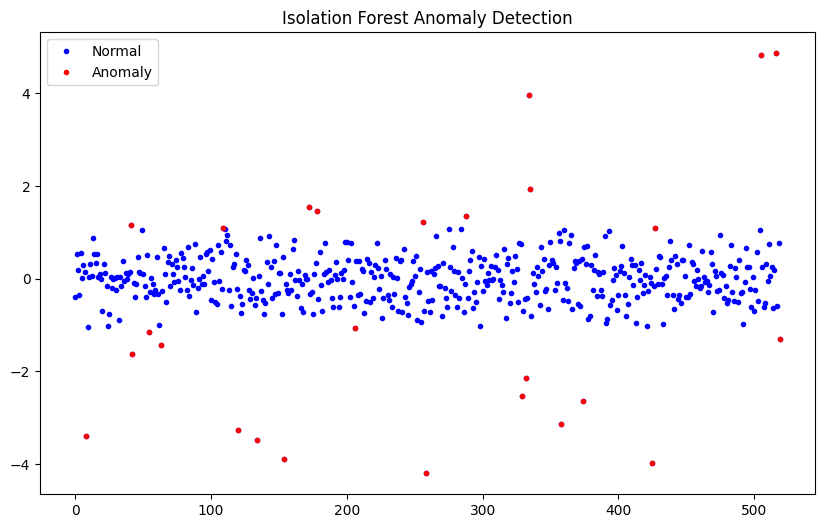

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


# Generate synthetic data
np.random.seed(42)
normal_data = np.random.normal(0, 0.5, 500)
anomalies = np.random.uniform(-5, 5, 20)
data = np.concatenate([normal_data, anomalies])
np.random.shuffle(data)

# Reshape data
X = data.reshape(-1, 1)

# Train model
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)

# Get predictions
predictions = model.predict(X)

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(data, 'b.', label='Normal')
plt.plot(np.where(predictions == -1)[0], data[predictions == -1], 'r.', label='Anomaly')
plt.title("Isolation Forest Anomaly Detection")
plt.legend()
plt.show()